# NHANES project about Periodontal disease: descriptive and regression analysis
> This notebook has the purpose to collect all the analysis on Nhanes dataset for a medical paper project 

Requirements and Information:
1. Nhanes dataset from 2009/10 to 2013/14
2. 5 Intrinsic Capacity domains
    1. Locomotion:
        - Standingup from armless chair difficulty (PFQ061I)
    2. Cognitive Function:
        - Have serious difficulty concentrating (DLQ040)
    3. Vitality:
        - Weight change intentional (WHQ060)
        - Poor appetite or overeating (DPQ050)
    4. Psychological status:
        - Feeling down, depressed, or hopeless (DPQ020)
        - Have little interest in doing things (DPQ010)
    5. Sensory domain:
        - Have serious difficulty hearing? (DLQ010)
        - Have serious difficulty seeing? (DLQ020)
3. Outcome:
    - calculated using Periodontal Exam (OHXPER_H) and CDC/AAP criteria (Eke et al., 2012)
    - consists of 3 categories: None/Mild, Moderate, Severe
4. Confounding Variables:
    - Gender (RIAGENDR)
    - Age at screening (RIDAGEYR)
    - Race (RIDRETH1)
    - Education	(DMDEDUC2)
    - Poverty income ratio (INDFMPIR)
    - Smoking status (SMQ020)
5. Mediators:
    - Heart failure	(RIDRETH1)  
    - Coronary heart disease (MCQ160b)
    - Stroke (MCQ160c)
    - Liver disease	(MCQ160o)
    - Cancer (MCQ500)
    - Diabetes (MCQ220)
    - High blood pressure (DIQ010)
6. Age => 60

## NHANES 2013/14: Intrinsic Capacity and Periodontal disease

### Import Libraries

In [25]:
library(haven)
library(nhanesA)
library(survey)
library(MASS)
library(dplyr)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(readr)
library(flextable)
library(officer)
library(nnet)
library(broom)
library(ggplot2)

### Configurations

In [26]:
path_to_data <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2013_14/"

path_to_data_09_10 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2009_10/"
path_to_data_11_12 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2011_12/"

### Load Dataset & Feature Selection

In [ ]:
# Datasets for 2009/10 period

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_selected <- demo_09_10 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_09_10 <- read_xpt(file.path(path_to_data_09_10, "ALQ_F.xpt"))

alcohol_09_10_selected <- alcohol_09_10 %>%
  select(SEQN, ALQ101)

smoking_09_10 <- read_xpt(file.path(path_to_data_09_10, "SMQ_F.xpt.txt"))

smoking_09_10_selected <- smoking_09_10 %>%
    select(SEQN, SMQ020)

med_conditions_09_10 <- read_xpt(file.path(path_to_data_09_10, "MCQ_F.xpt"))

med_conditions_09_10_selected <- med_conditions_09_10 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_09_10_selected <- med_conditions_09_10_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_09_10 <- read_xpt(file.path(path_to_data_09_10, "BPQ_F.xpt"))

blood_pressure_09_10_selected <- blood_pressure_09_10 %>%
    select(SEQN, BPQ020)


diabetes_09_10 <- read_xpt(file.path(path_to_data_09_10, "DIQ_F.xpt"))

diabetes_09_10_selected <- diabetes_09_10 %>%
    select(SEQN, DIQ010)


periodontal_09_10 <- read_xpt(file.path(path_to_data_09_10, "OHXPER_F.xpt.txt"))

selected_cols <- colnames(periodontal_09_10)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_09_10))]

periodontal_09_10_selected <- periodontal_09_10 %>%
    select(SEQN, all_of(selected_cols))


locomotion_09_10 <- read_xpt(file.path(path_to_data_09_10, "PFQ_F.xpt"))

locomotion_09_10_selected <- locomotion_09_10 %>%
    select(SEQN, PFQ061I)


mental_health_09_10 <- read_xpt(file.path(path_to_data_09_10, "DPQ_F.xpt"))

mental_health_09_10_selected <- mental_health_09_10 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_09_10 <- read_xpt(file.path(path_to_data_09_10, "WHQ_F.xpt"))

weight_history_09_10_selected <- weight_history_09_10 %>%
    select(SEQN, WHQ060)


audiometry_09_10 <- read_xpt(file.path(path_to_data_09_10, "AUQ_F.xpt"))

audiometry_09_10_selected <- audiometry_09_10 %>%
    select(SEQN, AUQ131)

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  mutate(AUQ131 = case_when(
    AUQ131 %in% c(1, 2, 3) ~ 2,
    AUQ131 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ131
  ))

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  rename(DLQ010 = AUQ131)

In [ ]:
# Datasets for 2011/12 period

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_selected <- demo_11_12 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_11_12 <- read_xpt(file.path(path_to_data_11_12, "ALQ_G.xpt.txt"))

alcohol_11_12_selected <- alcohol_11_12 %>%
  select(SEQN, ALQ101)


smoking_11_12 <- read_xpt(file.path(path_to_data_11_12, "SMQ_G.xpt.txt"))

smoking_11_12_selected <- smoking_11_12 %>%
    select(SEQN, SMQ020)


med_conditions_11_12 <- read_xpt(file.path(path_to_data_11_12, "MCQ_G.xpt.txt"))

med_conditions_11_12_selected <- med_conditions_11_12 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_11_12_selected <- med_conditions_11_12_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_11_12 <- read_xpt(file.path(path_to_data_11_12, "BPQ_G.xpt.txt"))

blood_pressure_11_12_selected <- blood_pressure_11_12 %>%
    select(SEQN, BPQ020)


diabetes_11_12 <- read_xpt(file.path(path_to_data_11_12, "DIQ_G.xpt.txt"))

diabetes_11_12_selected <- diabetes_11_12 %>%
    select(SEQN, DIQ010)


periodontal_11_12 <- read_xpt(file.path(path_to_data_11_12, "OHXPER_G.xpt.txt"))

selected_cols <- colnames(periodontal_11_12)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_11_12))]

periodontal_11_12_selected <- periodontal_11_12 %>%
    select(SEQN, all_of(selected_cols))


locomotion_11_12 <- read_xpt(file.path(path_to_data_11_12, "PFQ_G.xpt.txt"))

locomotion_11_12_selected <- locomotion_11_12 %>%
    select(SEQN, PFQ061I)


mental_health_11_12 <- read_xpt(file.path(path_to_data_11_12, "DPQ_G.xpt.txt"))

mental_health_11_12_selected <- mental_health_11_12 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_11_12 <- read_xpt(file.path(path_to_data_11_12, "WHQ_G.xpt.txt"))

weight_history_11_12_selected <- weight_history_11_12 %>%
    select(SEQN, WHQ060)


audiometry_11_12 <- read_xpt(file.path(path_to_data_11_12, "AUQ_G.xpt.txt"))

audiometry_11_12_selected <- audiometry_11_12 %>%
  select(SEQN, AUQ054)

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  mutate(AUQ054 = case_when(
    AUQ054 %in% c(1, 2, 3) ~ 2,
    AUQ054 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ054
  ))

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  rename(DLQ010 = AUQ054)

In [ ]:
# Datasets for 2013/14 period

demo_13_14 <- read_xpt(file.path(path_to_data, "DEMO_H.xpt.txt"))

demo_13_14_selected <- demo_13_14 %>%
    select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)


alcohol_13_14 <- read_xpt(file.path(path_to_data, "ALQ_H.xpt.txt"))

alcohol_13_14_selected <- alcohol_13_14 %>%
    select(SEQN, ALQ101)


smoking_13_14 <- read_xpt(file.path(path_to_data, "SMQ_H.xpt.txt"))

smoking_13_14_selected <- smoking_13_14 %>%
    select(SEQN, SMQ020)


med_conditions_13_14 <- read_xpt(file.path(path_to_data, "MCQ_H.xpt.txt"))

med_conditions_13_14_selected <- med_conditions_13_14 %>%
    select(SEQN, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)


blood_pressure_13_14 <- read_xpt(file.path(path_to_data, "BPQ_H.xpt.txt"))

blood_pressure_13_14_selected <- blood_pressure_13_14 %>%
    select(SEQN, BPQ020)


diabetes_13_14 <- read_xpt(file.path(path_to_data, "DIQ_H.xpt.txt"))

diabetes_13_14_selected <- diabetes_13_14 %>%
    select(SEQN, DIQ010)


periodontal_13_14 <- read_xpt(file.path(path_to_data, "OHXPER_H.xpt.txt"))

selected_cols <- colnames(periodontal_13_14)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_13_14))]

periodontal_13_14_selected <- periodontal_13_14 %>%
    select(SEQN, all_of(selected_cols))


locomotion_13_14 <- read_xpt(file.path(path_to_data, "PFQ061I.txt"))

locomotion_13_14_selected <- locomotion_13_14 %>%
    select(SEQN, PFQ061I)


disability_13_14 <- read_xpt(file.path(path_to_data, "DLQ040.txt"))

disability_13_14_selected <- disability_13_14 %>%
    select(SEQN, DLQ010, DLQ020, DLQ040)


mental_health_13_14 <- read_xpt(file.path(path_to_data, "DPQ-.txt"))

mental_health_13_14_selected <- mental_health_13_14 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050)


weight_history_13_14 <- read_xpt(file.path(path_to_data, "WHQ060.txt"))

weight_history_13_14_selected <- weight_history_13_14 %>%
    select(SEQN, WHQ060)

In [ ]:
# Dimensions for periodontal datasets

dim(periodontal_09_10_selected)
dim(periodontal_11_12_selected)
dim(periodontal_13_14_selected)

### Merge datasets without NA and missing values

#### First method
> Merge all data from each datasets and then exclude patients

In [ ]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected, periodontal_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected, periodontal_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected, periodontal_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

# Excluding patients with missing values in Intrinsic Capacity features

df_final_excluding_IC <- df_final_age_60[complete.cases(df_final_age_60[, c('DLQ020', 'PFQ061I', 'DPQ010', 'DPQ020', 'DPQ050', 'DLQ040', 'WHQ060', 'DLQ010')]), ]

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 7))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 99))

print("Dimensions without IC missing values")
dim(df_final_excluding_IC)

# Excluding patients with no examinations for Periodontitis Disease features

df_final_excluding_PD <- df_final_excluding_IC %>%
  filter(rowSums(!is.na(select(., starts_with("OHX")))) > 0)

print("Dimensions without PD missing values")
dim(df_final_excluding_PD)

# Excluding Edentulia

df_final_excluding_edentulus <- df_final_excluding_PD %>%
  filter(rowSums(select(., starts_with("OHX")) == 99, na.rm = FALSE) < ncol(select(., starts_with("OHX"))))

print("Dimensions without Edentulus patients")
dim(df_final_excluding_edentulus)

# Excluding patients with missing values in Confounding features

df_final_excluding_confounding <- df_final_excluding_edentulus[complete.cases(df_final_excluding_edentulus[, 
                                  c('RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDFMPIR', 'ALQ101', 'SMQ020', 'MCQ160B',
                                  'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160L', 'MCQ220', 'BPQ020', 'DIQ010')]), ]

df_final_merged <- df_final_excluding_confounding %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, MCQ160B, MCQ160C, MCQ160D,
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010), ~ . == 9))

print("Dimensions without Confounding missing values")
dim(df_final_merged)

#### Second method
> Merge demographics and intrinsic capacity data from each datasets, then exclude patients, at the end merge this dataset with periodontal data

In [ ]:
# Vertical union for periodontal data: removing patients with 0 teeth 

df_periodontal <- bind_rows(periodontal_09_10_selected, periodontal_11_12_selected, periodontal_13_14_selected)

df_periodontal_clean <- df_periodontal[rowSums(df_periodontal[, colnames(df_periodontal) != "SEQN"] == 99) != (ncol(df_periodontal) - 1), ]

print(paste("Deleted Rows:", nrow(df_periodontal) - nrow(df_periodontal_clean)))

dim(df_periodontal_clean)

In [ ]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

# Remove NA values

df_final <- na.omit(df_final)

df_final <- df_final %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, DLQ020, MCQ160B, MCQ160C, MCQ160D, 
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010, PFQ061I, 
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final <- df_final %>%
  filter(!if_any(c(DPQ010), ~ . == 7))

df_final <- df_final %>%
  filter(!if_any(c(DLQ010), ~ . == 99))

print("Dimensions after removing NA values")
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

In [ ]:
# Merge df_final_age_60 with features for periodontal disease

df_final_merged <- df_final_age_60 %>%
  inner_join(df_periodontal_clean, by = "SEQN")

dim(df_final_merged)

#### Save df cleaned

In [ ]:
# Saving completed and cleaned dataframe for analysis

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/merged_and_cleaned_df_09_14.csv")

### Periodontitis Classification

In [ ]:
classify_periodontitis <- function(df) {
  # Function to count sites on different teeth that meet a criterion
  count_sites_different_teeth <- function(tooth_sites,
                                          threshold, measurement_type) {
    teeth_with_sites <- list()
    for(tooth in unique(sub("(OHX\\d+).*", "\\1", names(tooth_sites)))) {
      # Include all interproximal sites
      # S = mesio-facial, D = distal, A = mesio-lingual, P = disto-lingual
      tooth_cols <- grep(paste0(tooth, measurement_type, "[SDAP]$"), 
                        names(tooth_sites), value = TRUE)
      values <- as.numeric(tooth_sites[tooth_cols])
      valid_values <- values[values != 99 & !is.na(values)]
      # If at least one site exceeds the threshold, add to list
      if(length(valid_values) > 0 && any(valid_values >= threshold)) {
        teeth_with_sites <- c(teeth_with_sites, tooth)
      }
    }
    # Returns the number of different teeth with sites exceeding the threshold
    return(length(teeth_with_sites))
  }

  ppd_cols <- grep("PC[SDAP]$", names(df), value = TRUE)
  cal_cols <- grep("LA[SDAP]$", names(df), value = TRUE)

  # Initializes the columns for classification
  df$severe <- FALSE
  df$moderate <- FALSE
  df$mild <- FALSE

  for(i in 1:nrow(df)) {
    ppd_values <- df[i, ppd_cols]
    cal_values <- df[i, cal_cols]

    # Counts teeth with sites that meet the criteria
    teeth_with_cal_6mm <- count_sites_different_teeth(cal_values, 6, "LA")
    teeth_with_cal_4mm <- count_sites_different_teeth(cal_values, 4, "LA")
    teeth_with_cal_3mm <- count_sites_different_teeth(cal_values, 3, "LA")
    teeth_with_ppd_5mm <- count_sites_different_teeth(ppd_values, 5, "PC")
    teeth_with_ppd_4mm <- count_sites_different_teeth(ppd_values, 4, "PC")

    # Severe periodontitis classification
    # ≥2 teeth with interproximal sites CAL ≥6 mm AND ≥1 tooth with PPD ≥5 mm
    if(teeth_with_cal_6mm >= 2 && teeth_with_ppd_5mm >= 1) {
      df$severe[i] <- TRUE
    }
    # Moderate periodontitis classification
    # ≥2 teeth with interproximal sites CAL ≥4 mm OR ≥2 tooth with PPD ≥5 mm
    else if(teeth_with_cal_4mm >= 2 || teeth_with_ppd_5mm >= 2) {
      df$moderate[i] <- TRUE
    }
    # Mild periodontitis
    # ≥2 teeth with interproximal sites CAL ≥3 mm AND
    # ≥2 teeth with interproximal sites PPD ≥4 mm
    else if(teeth_with_cal_3mm >= 2 &&
              teeth_with_ppd_4mm >= 2) {
      df$mild[i] <- TRUE
    }
  }

  # Final Classification
  df$periodontitis <- case_when(
    df$severe ~ "Severe",
    df$moderate ~ "Moderate",
    #TRUE ~ "None/Mild"
    df$mild ~ "Mild",
    TRUE ~ "None"
  )

  return(df)
}

In [ ]:
df_classification <- classify_periodontitis(df_final_merged)

In [ ]:
table_counts <- table(df_classification$periodontitis)
table_percent <- prop.table(table_counts) * 100

print("Distribution of periodontitis categories (counting):")
print(table_counts)

print("Distribution of periodontitis categories (percentage):")
print(round(table_percent, 2))

### Calculate Mean PPD and Mean CAL

In [ ]:
calculate_means <- function(df) {
  # Select columns for interproximal sites
  ppd_cols <- grep("PC[SDAP]$", names(df), value = TRUE)
  cal_cols <- grep("LA[SDAP]$", names(df), value = TRUE)
  
  # Calculate the average excluding invalid values
  calculate_valid_mean <- function(row, cols) {
    values <- as.numeric(row[cols])
    valid_values <- values[values != 99 & !is.na(values)]
    if(length(valid_values) > 0) {
      return(mean(valid_values, na.rm = TRUE))
    } else {
      return(NA)
    }
  }
  
  df$mean_ppd <- apply(df[ppd_cols], 1, calculate_valid_mean, cols = ppd_cols)
  df$mean_cal <- apply(df[cal_cols], 1, calculate_valid_mean, cols = cal_cols)
  
  df$mean_ppd <- round(df$mean_ppd, 2)
  df$mean_cal <- round(df$mean_cal, 2)
  
  return(df)
}

In [ ]:
df_class_with_means <- calculate_means(df_classification)

dim(df_class_with_means)
head(df_class_with_means)

### Features selection

In [ ]:
# Features selection for the descriptive and regression analysis

columns_to_keep <- c("SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH1",
                     "DMDEDUC2", "INDFMPIR",
                     "SMQ020", "ALQ101", "MCQ160B", "MCQ160C",
                     "MCQ160D", "MCQ160E", "MCQ160F",
                     "MCQ160L", "MCQ220", "BPQ020",
                     "DIQ010", "PFQ061I",
                     "DLQ010", "DLQ020", "DLQ040",
                     "DPQ010", "DPQ020", "DPQ050", "WHQ060",
                     "periodontitis", "mean_ppd", "mean_cal")

df <- df_class_with_means[, columns_to_keep]

dim(df)
head(df)

In [ ]:
write.csv(df, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/preprocessed_df_09_14.csv", row.names=FALSE)

### Descriptive analysis

In [ ]:
# Function for the descriptive analysis

create_descriptive_table <- function(df) {
  require(tableone)
  require(dplyr)

  df$periodontitis <- factor(df$periodontitis, levels = c("None", "Mild", "Moderate", "Severe"))
  
  # Recoding categorical variables
  df <- df %>%
    mutate(
      `Age (years)` = RIDAGEYR,
      `Ratio of family income` = INDFMPIR,
      `Mean PPD` = mean_ppd,
      `Mean CAL` = mean_cal,
      Gender = factor(RIAGENDR, levels = c(1, 2), 
                      labels = c("Male", "Female")),
      
      Ethnicity = factor(RIDRETH1, levels = 1:5, 
                         labels = c("Mexican American", "Other Hispanic",
                                    "Non-Hispanic White", "Non-Hispanic Black",
                                    "Other Race")),
      
      Education = factor(DMDEDUC2, levels = 1:5,
                         labels = c("Less than 9th grade", "9-11th grade",
                                    "High school graduate",
                                    "Some college/AA degree",
                                    "College graduate or above")),
      
      Smoking = factor(SMQ020, levels = c(1, 2),
                       labels = c("Yes", "No")),
      
      `Alcohol intake` = factor(ALQ101, levels = c(1, 2),
                       labels = c("Over 12 alcohol drinks/1 yr",
                       "Under 12 alcohol drinks/1 yr")),
      
      `Heart Failure` = factor(MCQ160B, levels = c(1, 2), 
                             labels = c("Yes", "No")),
      `Coronary Heart` = factor(MCQ160C, levels = c(1, 2),
                              labels = c("Yes", "No")),
      Angina = factor(MCQ160D, levels = c(1, 2),
                      labels = c("Yes", "No")),
      `Heart Attack` = factor(MCQ160E, levels = c(1, 2),
                            labels = c("Yes", "No")),
      Stroke = factor(MCQ160F, levels = c(1, 2),
                      labels = c("Yes", "No")),
      Cancer = factor(MCQ220, levels = c(1, 2),
                    labels = c("Yes", "No")),
      Liver = factor(MCQ160L, levels = c(1, 2),
                     labels = c("Yes", "No")),
      Hypertension = factor(BPQ020, levels = c(1,2),
                            labels = c("Yes", "No")),
      Diabetes = factor(DIQ010, levels = 1:3,
                        labels = c("Yes", "No", "Borderline"))
    )
  
  continuous_vars <- c("Age (years)", "Ratio of family income", "Mean PPD", "Mean CAL")
  
  categorical_vars <- c("Gender", "Ethnicity", "Education", "Smoking", "Alcohol intake",
                        "Heart Failure", "Coronary Heart", "Angina", "Heart Attack",
                        "Stroke", "Cancer", "Liver", "Hypertension", "Diabetes")

  table1 <- CreateTableOne(vars = c(continuous_vars, categorical_vars),
                           strata = "periodontitis",
                           data = df,
                           test = TRUE)

  cont_vars_overall <- c("Age (years)", "Ratio of family income")
  
  table_overall <- CreateTableOne(vars = c(cont_vars_overall, categorical_vars),
                                  data = df,
                                  test = FALSE)
  
  formatted_table <- print(table1,
                           #nonnormal = continuous_vars,
                           nonnormal = NULL,
                           contDigits = 2,
                           showAllLevels = TRUE,
                           printToggle = FALSE,
                           smd = FALSE)
  
  formatted_table_overall <- print(table_overall,
                                   #nonnormal = continuous_vars,
                                   nonnormal = NULL,
                                   contDigits = 2,
                                   showAllLevels = TRUE,
                                   printToggle = FALSE,
                                   smd = FALSE)
  
  final_table <- list("Stratified by periodontitis" = formatted_table, 
                      "Overall" = formatted_table_overall)
  
  return(final_table)
}

In [ ]:
descriptive_table <- create_descriptive_table(df)

descriptive_table

In [ ]:
# Save tables as csv files

write.csv(descriptive_table$`Stratified by periodontitis`,
          "descriptive_table_stratified.csv", row.names = TRUE)

write.csv(descriptive_table$Overall,
          "descriptive_table_overall.csv", row.names = TRUE)

### Regression Analysis

#### Load Preprocessed Data + Recoded outcome and some variables

In [ ]:
# Load preprocessed and cleaned df

df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/preprocessed_df_09_14.csv",
               header = TRUE)

head(df)

In [ ]:
# Recoding of the outcome with 3 levels: "None/Mild", "Moderate", "Severe"

df <- df %>%
  mutate(periodontitis = recode(periodontitis,
                                "Mild" = "None/Mild",
                                "None" = "None/Mild"))

df$periodontitis <- factor(df$periodontitis,
                           levels = c("None/Mild", "Moderate", "Severe"),
                           ordered = TRUE)

In [ ]:
table(df$periodontitis)

In [ ]:
# Create a df copy (just in case)

df_prove <- df

In [ ]:
# Recoding binary variables (1/2 -> 0/1): 0 as "No", 1 as "Yes"

binary_vars <- c("DLQ040", "WHQ060", "DLQ010", "DLQ020")
for(var in binary_vars) {
  df_prove[[var]] <- ifelse(df_prove[[var]] == 1, 1, 0)
}

In [ ]:
# Recoding multi level variables as binary variable: 0 as "No", 1 as "Yes"

df_prove <- df_prove %>% mutate(
  # Locomotion
  PFQ061I_bin = ifelse(PFQ061I == 1, 0, 1),
  
  # Vitality
  DPQ050_bin = ifelse(DPQ050 == 0, 0, 1),
  
  # Psychological
  DPQ020_bin = ifelse(DPQ020 == 0, 0, 1),
  DPQ010_bin = ifelse(DPQ010 == 0, 0, 1)
)

In [ ]:
# Saving recoded df

write.csv(df_prove, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", row.names = FALSE)

#### Crude and Adjusted Logistic Regression analysis with periodontitis outcome

In [ ]:
df_prove <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df_prove)

In [ ]:
# Function to run a crude & adjusted logistic regression analysis

run_logistic_analysis <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Crude Analysis
    # Overall
    model_crude_overall <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df)
    
    # Only Male
    model_crude_males <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                             family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Only Female
    model_crude_females <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ perio_binary + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = subset_df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ perio_binary + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males = glm(as.formula(paste(outcome, gender_formula)),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Females only
    model_adj_females = glm(as.formula(paste(outcome, gender_formula)),
                        family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])
    
    # Saving results
    results[[perio_type]] <- list(
      crude = list(
        overall = get_model_stats(model_crude_overall),
        males = get_model_stats(model_crude_males),
        females = get_model_stats(model_crude_females)
      ),
      adjusted = list(
        overall = get_model_stats(model_adj_overall),
        males = get_model_stats(model_adj_males),
        females = get_model_stats(model_adj_females)
      )
    )
  }
  return(results)
}

In [ ]:
# Function to run only crude logistic regression analysis

run_crude_logistic_analysis <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]

    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Crude Analysis
    # Overall
    model_crude_overall <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df)
    
    # Only Male
    model_crude_males <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                             family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Only Female
    model_crude_females <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])
    
    results[[perio_type]] = list(
      overall = get_model_stats(model_crude_overall),
      males = get_model_stats(model_crude_males),
      females = get_model_stats(model_crude_females)
    )
  }
  
  return(results)
}

In [ ]:
# Function to run only adjusted logistic regression analysis

run_adjusted_logistic_analysis <- function(df, outcome) {
  results = list()

  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    pred_idx <- which(rownames(coef_summary$coefficients) == "perio_binary")
    or <- exp(coef(model)[pred_idx])
    ci <- exp(confint(model)[pred_idx,])
    p_value <- coef_summary$coefficients[pred_idx,4]
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ perio_binary + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                        family = binomial, data = subset_df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ perio_binary + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males = glm(as.formula(paste(outcome, gender_formula)),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Females only
    model_adj_females = glm(as.formula(paste(outcome, gender_formula)),
                        family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    results[[perio_type]] = list(
      overall = get_model_stats(model_adj_overall),
      males = get_model_stats(model_adj_males),
      females = get_model_stats(model_adj_females)
    )
  }
  
  return(results)
}

In [ ]:
# Function to format results in a precise table (for single analysis)

format_results_single_analysis <- function(results_list, predictors) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Moderate (Overall)` = character(),
    `Moderate (Males)` = character(),
    `Moderate (Females)` = character(),
    `Severe (Overall)` = character(),
    `Severe (Males)` = character(),
    `Severe (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                   ifelse(stats$p < 0.01, "**",
                          ifelse(stats$p < 0.05, "*", "")))
    
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  for(pred in names(results_list)) {
    res <- results_list[[pred]]
    
    row <- data.frame(
      Predictor = pred,
      `Moderate (Overall)` = format_stats(res$moderate$overall),
      `Moderate (Males)` = format_stats(res$moderate$males),
      `Moderate (Females)` = format_stats(res$moderate$females),
      `Severe (Overall)` = format_stats(res$severe$overall),
      `Severe (Males)` = format_stats(res$severe$males),
      `Severe (Females)` = format_stats(res$severe$females)
    )
    
    formatted_table <- rbind(formatted_table, row)
  }
  
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  formatted_table$Predictor <- predictor_names[formatted_table$Predictor]
  
  formatted_table <- formatted_table[match(predictor_names, formatted_table$Predictor), ]
  
  return(formatted_table)
}

In [ ]:
# Function to format results with domain names, and crude/adjusted rows

format_results <- function(results_list, outcomes) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Moderate (Overall)` = character(),
    `Moderate (Males)` = character(),
    `Moderate (Females)` = character(),
    `Severe (Overall)` = character(),
    `Severe (Males)` = character(),
    `Severe (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                    ifelse(stats$p < 0.01, "**",
                           ifelse(stats$p < 0.05, "*", "")))
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  # Outcome names (name to be changed)
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  for(outcome in names(results_list)) {
    res <- results_list[[outcome]]
    
    domain_row <- data.frame(
      Predictor = predictor_names[outcome],
      `Moderate (Overall)` = "",
      `Moderate (Males)` = "",
      `Moderate (Females)` = "",
      `Severe (Overall)` = "",
      `Severe (Males)` = "",
      `Severe (Females)` = "",
      stringsAsFactors = FALSE
    )
    
    crude_row <- data.frame(
      Predictor = "Crude",
      `Moderate (Overall)` = format_stats(res$moderate$crude$overall),
      `Moderate (Males)` = format_stats(res$moderate$crude$males),
      `Moderate (Females)` = format_stats(res$moderate$crude$females),
      `Severe (Overall)` = format_stats(res$severe$crude$overall),
      `Severe (Males)` = format_stats(res$severe$crude$males),
      `Severe (Females)` = format_stats(res$severe$crude$females),
      stringsAsFactors = FALSE
    )
    
    adjusted_row <- data.frame(
      Predictor = "Adjusted",
      `Moderate (Overall)` = format_stats(res$moderate$adjusted$overall),
      `Moderate (Males)` = format_stats(res$moderate$adjusted$males),
      `Moderate (Females)` = format_stats(res$moderate$adjusted$females),
      `Severe (Overall)` = format_stats(res$severe$adjusted$overall),
      `Severe (Males)` = format_stats(res$severe$adjusted$males),
      `Severe (Females)` = format_stats(res$severe$adjusted$females),
      stringsAsFactors = FALSE
    )
    
    formatted_table <- rbind(formatted_table, domain_row, crude_row, adjusted_row)
  }
  
  ordered_outcomes <- names(predictor_names)
  row_indices <- c()
  
  for (outcome in ordered_outcomes) {
    domain_idx <- which(formatted_table$Predictor == predictor_names[outcome])
    if (length(domain_idx) > 0) {
      row_indices <- c(row_indices, domain_idx, domain_idx + 1, domain_idx + 2)
    }
  }
  
  if (length(row_indices) == nrow(formatted_table)) {
    formatted_table <- formatted_table[row_indices, ]
  }
  
  return(formatted_table)
}

In [ ]:
# Perform Crude & Adjusted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(outcomes, function(pred) run_logistic_analysis(df_prove, pred)),
  outcomes
)

final_table <- format_results(results_list, outcomes)
final_table

In [ ]:
# Saving Table in the csv format

csv_table <- final_table
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/completed_regression_analysis.csv", row.names = FALSE)

In [ ]:
# Perform Crude Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list_crude <- setNames(
  lapply(outcomes, function(pred) run_crude_logistic_analysis(df_prove, pred)),
  outcomes
)

final_table_crude <- format_results_single_analysis(results_list_crude, outcomes)
final_table_crude

In [ ]:
# Perform Adjusted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list_adjusted <- setNames(
  lapply(outcomes, function(pred) run_adjusted_logistic_analysis(df_prove, pred)),
  outcomes
)

final_table_adjusted <- format_results_single_analysis(results_list_adjusted, outcomes)
final_table_adjusted

In [ ]:
# Saving Crude Table in the csv format

csv_table <- final_table_crude
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/crude_logistic_regression_results.csv", row.names = FALSE)

In [ ]:
# Saving Adjusted Table in the csv format

csv_table <- final_table_adjusted
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/adjusted_logistic_regression_results.csv", row.names = FALSE)

#### Visualize Results using separated results

In [ ]:
# Function to prepare data for the forest plot from results_list

prepare_forest_data_from_list <- function(results_list, outcome_type, analysis_type, predictor_names) {
  plot_data <- data.frame(
    predictor = character(),
    predictor_label = character(),
    or = numeric(),
    ci_low = numeric(),
    ci_high = numeric(),
    p_value = numeric(),
    stringsAsFactors = FALSE
  )
  
  for(pred in names(results_list)) {
    if(outcome_type %in% names(results_list[[pred]]) && 
       analysis_type %in% names(results_list[[pred]][[outcome_type]])) {
      
      result <- results_list[[pred]][[outcome_type]][[analysis_type]]
      
      if(pred %in% names(predictor_names)) {
        pred_label <- predictor_names[[pred]]
      } else {
        pred_label <- pred
      }
      
      plot_data <- rbind(plot_data, data.frame(
        predictor = pred,
        predictor_label = pred_label,
        or = result$or[1],
        ci_low = result$ci_low[1],
        ci_high = result$ci_high[1],
        p_value = result$p,
        stringsAsFactors = FALSE
      ))
    }
  }
  
  plot_data <- plot_data[order(plot_data$or), ]
  
  return(plot_data)
}

# Function to create the forest plot
create_odds_ratio_forest_plot <- function(plot_data, title) {
  plot_data$or_ci_text <- sprintf("%.2f (%.2f-%.2f)", 
                                 plot_data$or, 
                                 plot_data$ci_low, 
                                 plot_data$ci_high)
  
  plot_data$p_text <- ifelse(plot_data$p_value < 0.001, "0.000", 
                            sprintf("%.3f", plot_data$p_value))
  
  x_max <- max(plot_data$ci_high, na.rm = TRUE) * 1.25
  x_min <- min(0.875, min(plot_data$ci_low, na.rm = TRUE) * 0.9)
  
  ggplot(plot_data, aes(x = or, y = reorder(predictor_label, or))) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "grey50") +
    geom_point(shape = 15, size = 9, color = "darkgreen") +
    geom_errorbarh(aes(xmin = ci_low, xmax = ci_high), height = 0.2, color = "darkgreen") +

    geom_text(aes(x = x_max * 0.83, label = or_ci_text), hjust = 0, size = 12, fontface = "bold") +
    geom_text(aes(x = x_max * 0.98, label = p_text), hjust = 0, size = 12, fontface = "bold") +

    theme_minimal() +
    theme(
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      axis.text.x = element_text(size = 27),
      axis.text.y = element_text(size = 44, face = "bold"),
      axis.title.x = element_text(size = 34, face = "bold"),
      plot.title = element_text(hjust = 0.5, size = 44, face = "bold")
    ) +
    
    labs(
      title = title,
      x = "OR",
      y = NULL,
      caption = ""
    ) +

    scale_x_continuous(
      limits = c(x_min, x_max),
      breaks = seq(round(x_min, 1), round(x_max, 1), by = 0.2),
      minor_breaks = NULL,
      guide = guide_axis(check.overlap = TRUE)
    ) + 
    theme(
      axis.line.x = element_line(color = "black"),
      axis.ticks.x = element_line(color = "black")
    )
}

##### Crude Regression Visualization

In [ ]:
# Forest Plot for Adjusted Regression Analysis

predictor_names <- c(
  "PFQ061I_bin" = "Locomotor Capacity",
  "DLQ040" = "Cognitive Capacity",
  "WHQ060" = "Vitality (Weight loss)",
  "DPQ050_bin" = "Vitality (Nutrition)",
  "DPQ020_bin" = "Psychological Capacity (Mood)",
  "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
  "DLQ010" = "Sensory Capacity (Hearing Capacity)",
  "DLQ020" = "Sensory Domain (Visual Capacity)"
)

crude_moderate_overall_data <- prepare_forest_data_from_list(results_list_crude, "moderate", "overall", predictor_names)

crude_moderate_plot <- create_odds_ratio_forest_plot(crude_moderate_overall_data, 
                                             "Crude logistic regression of Moderate VS None/Mild Periodontitis")

options(repr.plot.width = 34, repr.plot.height = 28)

ggsave("/Users/silvanoquarto/Desktop/datagrafico.png", width = 15, height = 10, units = "in", dpi = 300)

print(crude_moderate_plot)

In [ ]:
# Severe Periodontitis Visualization

crude_severe_overall_data <- prepare_forest_data_from_list(results_list_crude, "severe", "overall", predictor_names)
crude_severe_plot <- create_odds_ratio_forest_plot(crude_severe_overall_data, 
                                          "Crude logistic regression of Severe VS None/Mild Periodontitis")
crude_severe_plot

In [ ]:
# Moderate Periodontitis Visualization for Male subgroup 

crude_moderate_male_data <- prepare_forest_data_from_list(results_list_crude, "moderate", "males", predictor_names)
crude_moderate_male_plot <- create_odds_ratio_forest_plot(crude_moderate_male_data,
                                          "Male crude logistic regression of Moderate VS None/Mild Periodontitis")
crude_moderate_male_plot

In [ ]:
# Severe Periodontitis Visualization for Male subgroup 

crude_severe_male_data <- prepare_forest_data_from_list(results_list_crude, "severe", "males", predictor_names)
crude_severe_male_plot <- create_odds_ratio_forest_plot(crude_severe_male_data, 
                                          "Male crude logistic regression of Severe VS None/Mild Periodontitis")
crude_severe_male_plot

In [ ]:
# Moderate Periodontitis Visualization for Female subgroup 

crude_moderate_female_data <- prepare_forest_data_from_list(results_list_crude, "moderate", "females", predictor_names)
crude_moderate_female_plot <- create_odds_ratio_forest_plot(crude_moderate_female_data,
                                          "Female crude logistic regression of Moderate VS None/Mild Periodontitis")
crude_moderate_female_plot

In [ ]:
# Severe Periodontitis Visualization for Female subgroup 

crude_severe_female_data <- prepare_forest_data_from_list(results_list_crude, "severe", "females", predictor_names)
crude_severe_female_plot <- create_odds_ratio_forest_plot(crude_severe_female_data, 
                                          "Female crude logistic regression of Severe VS None/Mild Periodontitis")
crude_severe_female_plot

##### Adjusted Regression Visualization

In [ ]:
# Forest Plot for Adjusted Regression Analysis

predictor_names <- c(
  "PFQ061I_bin" = "Locomotor Capacity",
  "DLQ040" = "Cognitive Capacity",
  "WHQ060" = "Vitality (Weight loss)",
  "DPQ050_bin" = "Vitality (Nutrition)",
  "DPQ020_bin" = "Psychological Capacity (Mood)",
  "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
  "DLQ010" = "Sensory Capacity (Hearing Capacity)",
  "DLQ020" = "Sensory Domain (Visual Capacity)"
)

moderate_overall_data <- prepare_forest_data_from_list(results_list_adjusted, "moderate", "overall", predictor_names)

moderate_plot <- create_odds_ratio_forest_plot(moderate_overall_data, 
                                             "Adjusted logistic regression of Moderate VS None/Mild Periodontitis")

options(repr.plot.width = 14, repr.plot.height = 10)
print(moderate_plot)

In [ ]:
# Severe Periodontitis Visualization

severe_overall_data <- prepare_forest_data_from_list(results_list_adjusted, "severe", "overall", predictor_names)
severe_plot <- create_odds_ratio_forest_plot(severe_overall_data, 
                                          "Adjusted logistic regression of Severe VS None/Mild Periodontitis")
severe_plot

In [ ]:
# Moderate Periodontitis Visualization for Male subgroup 

moderate_male_data <- prepare_forest_data_from_list(results_list_adjusted, "moderate", "males", predictor_names)
moderate_male_plot <- create_odds_ratio_forest_plot(moderate_male_data,
                                          "Male adjusted logistic regression of Moderate VS None/Mild Periodontitis")
moderate_male_plot

In [ ]:
# Severe Periodontitis Visualization for Male subgroup 

severe_male_data <- prepare_forest_data_from_list(results_list_adjusted, "severe", "males", predictor_names)
severe_male_plot <- create_odds_ratio_forest_plot(severe_male_data, 
                                          "Male adjusted logistic regression of Severe VS None/Mild Periodontitis")
severe_male_plot

In [ ]:
# Moderate Periodontitis Visualization for Female subgroup 

moderate_female_data <- prepare_forest_data_from_list(results_list_adjusted, "moderate", "females", predictor_names)
moderate_female_plot <- create_odds_ratio_forest_plot(moderate_female_data,
                                          "Female adjusted logistic regression of Moderate VS None/Mild Periodontitis")
moderate_female_plot

In [ ]:
# Severe Periodontitis Visualization for Female subgroup 

severe_female_data <- prepare_forest_data_from_list(results_list_adjusted, "severe", "females", predictor_names)
severe_female_plot <- create_odds_ratio_forest_plot(severe_female_data, 
                                          "Female adjusted logistic regression of Severe VS None/Mild Periodontitis")
severe_female_plot

#### Crude and Adjusted Logistic Regression analysis with CAL and PPD means as outcome

In [ ]:
df_prove <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df_prove)

In [ ]:
# Function to run a crude & adjusted logistic regression analysis

run_logistic_analysis_mean_ppd_cal <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_pred in c("mean_ppd", "mean_cal")) {

    # Crude Analysis
    # Overall
    model_crude_overall <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                               family = binomial, data = df)
    
    # Only Male
    model_crude_males <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                             family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Only Female
    model_crude_females <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                               family = binomial, data = df[df$RIAGENDR == 2,])

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ ", perio_pred, " + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ ", perio_pred, " + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males = glm(as.formula(paste(outcome, gender_formula)),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Females only
    model_adj_females = glm(as.formula(paste(outcome, gender_formula)),
                        family = binomial, data = df[df$RIAGENDR == 2,])
    
    # Saving results
    results[[perio_pred]] <- list(
      crude = list(
        overall = get_model_stats(model_crude_overall),
        males = get_model_stats(model_crude_males),
        females = get_model_stats(model_crude_females)
      ),
      adjusted = list(
        overall = get_model_stats(model_adj_overall),
        males = get_model_stats(model_adj_males),
        females = get_model_stats(model_adj_females)
      )
    )
  }
  return(results)
}

In [ ]:
# Function to format results with domain names, and crude/adjusted rows

format_results_mean_ppd_cal <- function(results_list, outcomes) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Mean PPD (Overall)` = character(),
    `Mean PPD (Males)` = character(),
    `Mean PPD (Females)` = character(),
    `Mean CAL (Overall)` = character(),
    `Mean CAL (Males)` = character(),
    `Mean CAL (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                    ifelse(stats$p < 0.01, "**",
                           ifelse(stats$p < 0.05, "*", "")))
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  # Outcome names (name to be changed)
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  for(outcome in names(results_list)) {
    res <- results_list[[outcome]]
    
    domain_row <- data.frame(
      Predictor = predictor_names[outcome],
      `Mean PPD (Overall)` = "",
      `Mean PPD (Males)` = "",
      `Mean PPD (Females)` = "",
      `Mean CAL (Overall)` = "",
      `Mean CAL (Males)` = "",
      `Mean CAL (Females)` = "",
      stringsAsFactors = FALSE
    )
    
    crude_row <- data.frame(
      Predictor = "Crude",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$crude$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$crude$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$crude$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$crude$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$crude$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$crude$females),
      stringsAsFactors = FALSE
    )
    
    adjusted_row <- data.frame(
      Predictor = "Adjusted",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$adjusted$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$adjusted$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$adjusted$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$adjusted$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$adjusted$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$adjusted$females),
      stringsAsFactors = FALSE
    )
    
    formatted_table <- rbind(formatted_table, domain_row, crude_row, adjusted_row)
  }
  
  ordered_outcomes <- names(predictor_names)
  row_indices <- c()
  
  for (outcome in ordered_outcomes) {
    domain_idx <- which(formatted_table$Predictor == predictor_names[outcome])
    if (length(domain_idx) > 0) {
      row_indices <- c(row_indices, domain_idx, domain_idx + 1, domain_idx + 2)
    }
  }
  
  if (length(row_indices) == nrow(formatted_table)) {
    formatted_table <- formatted_table[row_indices, ]
  }
  
  return(formatted_table)
}

In [ ]:
# Perform Crude & Adjusted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list_mean_ppd_cal <- setNames(
  lapply(outcomes, function(pred) run_logistic_analysis_mean_ppd_cal(df_prove, pred)),
  outcomes
)

final_table_mean_ppd_cal <- format_results_mean_ppd_cal(results_list_mean_ppd_cal, outcomes)
final_table_mean_ppd_cal

In [ ]:
# Saving Table in the csv format

csv_table <- final_table_mean_ppd_cal
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Mean PPD - OR (95% CI) - Overall",
    "Mean PPD - OR (95% CI) - Males",
    "Mean PPD - OR (95% CI) - Females",
    "Mean CAL - OR (95% CI) - Overall",
    "Mean CAL - OR (95% CI) - Males",
    "Mean CAL - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/regression_analysis_mean_ppd_cal.csv", row.names = FALSE)

### Crude & Adjusted WHEIGHTED Logistic Regression Analysis

In [ ]:
df_prove <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df_prove)

In [ ]:
# Weights from Demographic datasets

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_weights <- demo_09_10 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_weights <- demo_11_12 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

demo_13_14 <- read_xpt(file.path(path_to_data, "DEMO_H.xpt.txt"))

demo_13_14_weights <- demo_13_14 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

weights_09_10 <- list(
  demo_09_10_weights
)

weights_11_12 <- list(
  demo_11_12_weights
)

weights_13_14 <- list(
  demo_13_14_weights
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

wt_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_09_10)

wt_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_11_12)

wt_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_13_14)

# Vertical union

wt_final <- bind_rows(wt_09_10, wt_11_12, wt_13_14)

print("Dimensions before removing NA values")
dim(wt_final)

# Filter with AGE >= 60

wt_final_age_60 <- subset(wt_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(wt_final_age_60)

wt_final_age_60 <- subset(wt_final_age_60, select = -RIDAGEYR)
head(wt_final_age_60)

In [ ]:
# Merge wt_final_age_60 with my final data frame 

df_final_merged <- df_prove %>%
  inner_join(wt_final_age_60, by = "SEQN")

dim(df_final_merged)

In [ ]:
# Preprocessing for WTMEC2YR: divide it for the number of NHANES cycles used (3 for our case)

df_final_merged[, "wt"] = df_final_merged[, "WTMEC2YR"] / 3

head(df_final_merged)

In [ ]:
# Function to run a crude & adjusted weighted logistic regression analysis

options(survey.lonely.psu = "adjust") 
options(survey.adjust.domain.lonely = TRUE)

run_weighted_logistic_analysis <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    pred_idx <- which(rownames(coef_summary$coefficients) == "perio_binary")
    or <- exp(coef(model)[pred_idx])
    ci <- exp(confint(model)[pred_idx,])
    p_value <- coef_summary$coefficients[pred_idx,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Define survey design
    subset_design <- survey::svydesign(id = ~SDMVPSU,
                           strata = ~SDMVSTRA,
                           weights = ~wt,
                           nest = TRUE,
                           data = subset_df)

    # Define subset for Gender subgroup analysis
    subset_design_male <- subset(subset_design, RIAGENDR == 1)
    subset_design_female <- subset(subset_design, RIAGENDR == 2)


    # Crude Analysis
    # Overall
    model_crude_overall <- survey::svyglm(as.formula(paste(outcome, " ~ perio_binary")),
                              family = quasibinomial, design = subset_design)
    
    # Only Male
    model_crude_males <- survey::svyglm(as.formula(paste(outcome, " ~ perio_binary")), 
                              family = quasibinomial, design = subset_design_male)
    
    # Only Female
    model_crude_females <- survey::svyglm(as.formula(paste(outcome, " ~ perio_binary")), 
                              family = quasibinomial, design = subset_design_female)

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ perio_binary + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall <- survey::svyglm(as.formula(paste(outcome, adjusted_formula)),
                              family = quasibinomial, design = subset_design)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ perio_binary + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males <- survey::svyglm(as.formula(paste(outcome, gender_formula)), 
                              family = quasibinomial, design = subset_design_male)
    
    # Females only
    model_adj_females <- survey::svyglm(as.formula(paste(outcome, gender_formula)), 
                              family = quasibinomial, design = subset_design_female)
    
    # Saving results
    results[[perio_type]] <- list(
      crude = list(
        overall = get_model_stats(model_crude_overall),
        males = get_model_stats(model_crude_males),
        females = get_model_stats(model_crude_females)
      ),
      adjusted = list(
        overall = get_model_stats(model_adj_overall),
        males = get_model_stats(model_adj_males),
        females = get_model_stats(model_adj_females)
      )
    )
  }
  return(results)
}

In [ ]:
# Function to format results with domain names, and crude/adjusted rows

format_results <- function(results_list, outcomes) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Moderate (Overall)` = character(),
    `Moderate (Males)` = character(),
    `Moderate (Females)` = character(),
    `Severe (Overall)` = character(),
    `Severe (Males)` = character(),
    `Severe (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                    ifelse(stats$p < 0.01, "**",
                           ifelse(stats$p < 0.05, "*", "")))
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  # Outcome names (name to be changed)
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  for(outcome in names(results_list)) {
    res <- results_list[[outcome]]
    
    domain_row <- data.frame(
      Predictor = predictor_names[outcome],
      `Moderate (Overall)` = "",
      `Moderate (Males)` = "",
      `Moderate (Females)` = "",
      `Severe (Overall)` = "",
      `Severe (Males)` = "",
      `Severe (Females)` = "",
      stringsAsFactors = FALSE
    )
    
    crude_row <- data.frame(
      Predictor = "Crude",
      `Moderate (Overall)` = format_stats(res$moderate$crude$overall),
      `Moderate (Males)` = format_stats(res$moderate$crude$males),
      `Moderate (Females)` = format_stats(res$moderate$crude$females),
      `Severe (Overall)` = format_stats(res$severe$crude$overall),
      `Severe (Males)` = format_stats(res$severe$crude$males),
      `Severe (Females)` = format_stats(res$severe$crude$females),
      stringsAsFactors = FALSE
    )
    
    adjusted_row <- data.frame(
      Predictor = "Adjusted",
      `Moderate (Overall)` = format_stats(res$moderate$adjusted$overall),
      `Moderate (Males)` = format_stats(res$moderate$adjusted$males),
      `Moderate (Females)` = format_stats(res$moderate$adjusted$females),
      `Severe (Overall)` = format_stats(res$severe$adjusted$overall),
      `Severe (Males)` = format_stats(res$severe$adjusted$males),
      `Severe (Females)` = format_stats(res$severe$adjusted$females),
      stringsAsFactors = FALSE
    )
    
    formatted_table <- rbind(formatted_table, domain_row, crude_row, adjusted_row)
  }
  
  ordered_outcomes <- names(predictor_names)
  row_indices <- c()
  
  for (outcome in ordered_outcomes) {
    domain_idx <- which(formatted_table$Predictor == predictor_names[outcome])
    if (length(domain_idx) > 0) {
      row_indices <- c(row_indices, domain_idx, domain_idx + 1, domain_idx + 2)
    }
  }
  
  if (length(row_indices) == nrow(formatted_table)) {
    formatted_table <- formatted_table[row_indices, ]
  }
  
  return(formatted_table)
}

In [ ]:
# Perform Crude & Adjusted Weighted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(outcomes, function(pred) run_weighted_logistic_analysis(df_final_merged, pred)),
  outcomes
)

final_table <- format_results(results_list, outcomes)
final_table

### Mediators Analysis

In [ ]:
df_prove <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df_prove)

#### Association between predictors and mediator 

In [ ]:
# Function to assess association between predictors and mediator 

predictor_vs_mediator <- function(df, mediator) {
  results = list()
  
  get_model_stats <- function(model, model_type) {
    if (model_type == "binomial" || model_type == "linear") {
      coef_summary <- summary(model)
      idx <- which(rownames(coef_summary$coefficients) == "perio_binary")
      
      if (model_type == "binomial") {
        or <- exp(coef(model)[idx])
        ci <- exp(confint(model)[idx,])
        p_value <- coef_summary$coefficients[idx,4]
        return(list(
          or = or,
          ci_low = ci[1],
          ci_high = ci[2],
          p = p_value
        ))
      } else {
        beta <- coef(model)[idx]
        ci <- confint(model)[idx,]
        p_value <- coef_summary$coefficients[idx,4]
        return(list(
          beta = beta,
          ci_low = ci[1],
          ci_high = ci[2],
          p = p_value
        ))
      }
    } else if (model_type == "multinomial") {
      coef_summary <- summary(model)
      z_values <- coef_summary$coefficients / coef_summary$standard.errors
      p_values <- 2 * (1 - pnorm(abs(z_values)))
      
      results_by_level <- list()
      
      for (i in 1:nrow(coef_summary$coefficients)) {
        level_name <- rownames(coef_summary$coefficients)[i]
        or <- exp(coef_summary$coefficients[i, "perio_binary"])
        se <- coef_summary$standard.errors[i, "perio_binary"]
        ci_low <- exp(coef_summary$coefficients[i, "perio_binary"] - 1.96 * se)
        ci_high <- exp(coef_summary$coefficients[i, "perio_binary"] + 1.96 * se)
        p_value <- p_values[i, "perio_binary"]
        
        results_by_level[[level_name]] <- list(
          or = or,
          ci_low = ci_low,
          ci_high = ci_high,
          p = p_value
        )
      }
      return(results_by_level)
    }
  }
  
  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }
    
    mediator_values <- subset_df[[mediator]]
    
    if(is.numeric(mediator_values)) {
      unique_values <- unique(mediator_values[!is.na(mediator_values)])
      
      if(length(unique_values) < 10 && all(unique_values == floor(unique_values))) {
        subset_df[[mediator]] <- factor(subset_df[[mediator]])
      }
    }
    
    mediator_values <- subset_df[[mediator]]
    mediator_unique <- length(unique(mediator_values[!is.na(mediator_values)]))
    
    if (is.factor(mediator_values) && mediator_unique > 2) {
      library(nnet)
      mediator_model <- multinom(as.formula(paste(mediator, "~ perio_binary")), 
                                data = subset_df)
      model_type <- "multinomial"
    } else if ((is.factor(mediator_values) && mediator_unique == 2) || 
               is.logical(mediator_values) || 
               (is.numeric(mediator_values) && all(mediator_values %in% c(0,1,NA)))) {
      mediator_model <- glm(as.formula(paste(mediator, "~ perio_binary")),
                           family = binomial, data = subset_df)
      model_type <- "binomial"
    } else if (is.numeric(mediator_values)) {
      mediator_model <- lm(as.formula(paste(mediator, "~ perio_binary")),
                          data = subset_df)
      model_type <- "linear"
    } else {
      warning(paste("Type of mediator not supported for", mediator))
      next
    }
    
    results[[perio_type]] <- list(
      mediator_case = get_model_stats(mediator_model, model_type)
    )
  }
  
  return(results)
}

In [ ]:
format_predictor_mediator_results <- function(results_list_med_pred) {
  formatted_results <- data.frame(
    Mediator = character(),
    Type = character(),
    Association = character(),
    P_value = numeric(),
    Significant = logical(),
    stringsAsFactors = FALSE
  )
  
  for (mediator_name in names(results_list_med_pred)) {
    mediator_results <- results_list_med_pred[[mediator_name]]
    
    for (perio_type in c("moderate", "severe")) {
      if (!is.null(mediator_results[[perio_type]])) {
        result <- mediator_results[[perio_type]]$mediator_case
        
        if (is.list(result)) {
          if (!is.null(result$overall)) {
            if (!is.null(result$overall$or)) {
              association <- sprintf("OR: %.2f (%.2f-%.2f)", 
                                    result$overall$or, 
                                    result$overall$ci_low, 
                                    result$overall$ci_high)
              p_val <- result$overall$p
            } else if (!is.null(result$overall$beta)) {
              association <- sprintf("β: %.2f (%.2f-%.2f)", 
                                    result$overall$beta, 
                                    result$overall$ci_low, 
                                    result$overall$ci_high)
              p_val <- result$overall$p
            } else {
              next
            }
            
            formatted_results <- rbind(formatted_results, data.frame(
              Mediator = mediator_name,
              Type = perio_type,
              Association = association,
              P_value = p_val,
              Significant = p_val < 0.05,
              stringsAsFactors = FALSE
            ))
          } 
          else {
            for (level_name in names(result)) {
              if (is.list(result[[level_name]])) {
                level_result <- result[[level_name]]
                
                if (!is.null(level_result$or)) {
                  association <- sprintf("OR: %.2f (%.2f-%.2f)", 
                                        level_result$or, 
                                        level_result$ci_low, 
                                        level_result$ci_high)
                  p_val <- level_result$p
                  
                  formatted_results <- rbind(formatted_results, data.frame(
                    Mediator = paste0(mediator_name, " (", level_name, ")"),
                    Type = perio_type,
                    Association = association,
                    P_value = p_val,
                    Significant = p_val < 0.05,
                    stringsAsFactors = FALSE
                  ))
                }
              }
            }
          }
        }
      }
    }
  }
  
  return(formatted_results)
}

In [ ]:
mediators <- c(
  "DIQ010", "BPQ020", "MCQ160B", "MCQ160C", "MCQ160E",
  "MCQ160F", "MCQ160L", "MCQ220"
)

results_list_med_pred <- setNames(
  lapply(mediators, function(med) predictor_vs_mediator(df_prove, med)),
  mediators
)

table_mediators <- format_predictor_mediator_results(results_list_med_pred)
table_mediators

#### Regression with mediators & Periodontitis Level 
> metric: p-values

In [ ]:
# Function to run a crude & adjusted logistic regression analysis

run_logistic_analysis_mediators <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Crude Analysis
    # Overall
    model_crude_overall <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df)
    
    # Only Male
    model_crude_males <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                             family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Only Female
    model_crude_females <- glm(as.formula(paste(outcome, " ~ perio_binary")), 
                               family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ perio_binary + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = subset_df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ perio_binary + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males = glm(as.formula(paste(outcome, gender_formula)),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    
    # Females only
    model_adj_females = glm(as.formula(paste(outcome, gender_formula)),
                        family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Diabetes
    base_diabetes_overall = glm(as.formula(paste(outcome, adjusted_formula, " + DIQ010")),
                       family = binomial, data = subset_df)

    base_diabetes_males = glm(as.formula(paste(outcome, gender_formula, " + DIQ010")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_diabetes_females = glm(as.formula(paste(outcome, gender_formula, " + DIQ010")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])
    
    # Overall with Base Model + Hypertension
    base_hypertension_overall = glm(as.formula(paste(outcome, adjusted_formula, " + BPQ020")),
                       family = binomial, data = subset_df)

    base_hypertension_males = glm(as.formula(paste(outcome, gender_formula, " + BPQ020")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_hypertension_females = glm(as.formula(paste(outcome, gender_formula, " + BPQ020")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Heart Failure
    base_failure_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160B")),
                       family = binomial, data = subset_df)

    base_failure_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160B")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_failure_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160B")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Coronary Heart Disease
    base_coronary_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160C")),
                       family = binomial, data = subset_df)

    base_coronary_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160C")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_coronary_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160C")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Heart Attack
    base_heartattack_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160E")),
                       family = binomial, data = subset_df)

    base_heartattack_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160E")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_heartattack_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160E")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Stroke
    base_stroke_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160F")),
                       family = binomial, data = subset_df)

    base_stroke_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160F")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_stroke_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160F")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Liver Disease
    base_liver_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160L")),
                       family = binomial, data = subset_df)

    base_liver_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160L")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_liver_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160L")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])

    # Overall with Base Model + Cancer
    base_cancer_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ220")),
                       family = binomial, data = subset_df)

    base_cancer_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ220")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 1,])
    base_cancer_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ220")),
                      family = binomial, data = subset_df[subset_df$RIAGENDR == 2,])
    
    # Saving results
    results[[perio_type]] <- list(
      crude = list(
        overall = get_model_stats(model_crude_overall),
        males = get_model_stats(model_crude_males),
        females = get_model_stats(model_crude_females)
      ),
      adjusted = list(
        overall = get_model_stats(model_adj_overall),
        males = get_model_stats(model_adj_males),
        females = get_model_stats(model_adj_females)
      ),
      base_diabetes = list(
        overall = get_model_stats(base_diabetes_overall),
        males = get_model_stats(base_diabetes_males),
        females = get_model_stats(base_diabetes_females)
      ),
      base_hypertension = list(
        overall = get_model_stats(base_hypertension_overall),
        males = get_model_stats(base_hypertension_males),
        females = get_model_stats(base_hypertension_females)
      ),
      base_failure = list(
        overall = get_model_stats(base_failure_overall),
        males = get_model_stats(base_failure_males),
        females = get_model_stats(base_failure_females)
      ),
      base_coronary = list(
        overall = get_model_stats(base_coronary_overall),
        males = get_model_stats(base_coronary_males),
        females = get_model_stats(base_coronary_females)
      ),
      base_heartattack = list(
        overall = get_model_stats(base_heartattack_overall),
        males = get_model_stats(base_heartattack_males),
        females = get_model_stats(base_heartattack_females)
      ),
      base_stroke = list(
        overall = get_model_stats(base_stroke_overall),
        males = get_model_stats(base_stroke_males),
        females = get_model_stats(base_stroke_females)
      ),
      base_liver = list(
        overall = get_model_stats(base_liver_overall),
        males = get_model_stats(base_liver_males),
        females = get_model_stats(base_liver_females)
      ),
      base_cancer = list(
        overall = get_model_stats(base_cancer_overall),
        males = get_model_stats(base_cancer_males),
        females = get_model_stats(base_cancer_females)
      )
    )
  }
  return(results)
}

In [ ]:
# Function to format results with domain names, and crude/adjusted rows and mediators analysis

format_results_mediators <- function(results_list, outcomes) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Moderate (Overall)` = character(),
    `Moderate (Males)` = character(),
    `Moderate (Females)` = character(),
    `Severe (Overall)` = character(),
    `Severe (Males)` = character(),
    `Severe (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                    ifelse(stats$p < 0.01, "**",
                           ifelse(stats$p < 0.05, "*", "")))
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  # Outcome names (name to be changed)
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  for(outcome in names(results_list)) {
    res <- results_list[[outcome]]
    
    domain_row <- data.frame(
      Predictor = predictor_names[outcome],
      `Moderate (Overall)` = "",
      `Moderate (Males)` = "",
      `Moderate (Females)` = "",
      `Severe (Overall)` = "",
      `Severe (Males)` = "",
      `Severe (Females)` = "",
      stringsAsFactors = FALSE
    )
    
    crude_row <- data.frame(
      Predictor = "Crude",
      `Moderate (Overall)` = format_stats(res$moderate$crude$overall),
      `Moderate (Males)` = format_stats(res$moderate$crude$males),
      `Moderate (Females)` = format_stats(res$moderate$crude$females),
      `Severe (Overall)` = format_stats(res$severe$crude$overall),
      `Severe (Males)` = format_stats(res$severe$crude$males),
      `Severe (Females)` = format_stats(res$severe$crude$females),
      stringsAsFactors = FALSE
    )
    
    adjusted_row <- data.frame(
      Predictor = "Adjusted",
      `Moderate (Overall)` = format_stats(res$moderate$adjusted$overall),
      `Moderate (Males)` = format_stats(res$moderate$adjusted$males),
      `Moderate (Females)` = format_stats(res$moderate$adjusted$females),
      `Severe (Overall)` = format_stats(res$severe$adjusted$overall),
      `Severe (Males)` = format_stats(res$severe$adjusted$males),
      `Severe (Females)` = format_stats(res$severe$adjusted$females),
      stringsAsFactors = FALSE
    )

    diabetes_row <- data.frame(
      Predictor = "+ Diabetes",
      `Moderate (Overall)` = format_stats(res$moderate$base_diabetes$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_diabetes$males),
      `Moderate (Females)` = format_stats(res$moderate$base_diabetes$females),
      `Severe (Overall)` = format_stats(res$severe$base_diabetes$overall),
      `Severe (Males)` = format_stats(res$severe$base_diabetes$males),
      `Severe (Females)` = format_stats(res$severe$base_diabetes$females),
      stringsAsFactors = FALSE
    )

    hypertension_row <- data.frame(
      Predictor = "+ Hypertension",
      `Moderate (Overall)` = format_stats(res$moderate$base_hypertension$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_hypertension$males),
      `Moderate (Females)` = format_stats(res$moderate$base_hypertension$females),
      `Severe (Overall)` = format_stats(res$severe$base_hypertension$overall),
      `Severe (Males)` = format_stats(res$severe$base_hypertension$males),
      `Severe (Females)` = format_stats(res$severe$base_hypertension$females),
      stringsAsFactors = FALSE
    )

    failure_row <- data.frame(
      Predictor = "+ Heart Failure",
      `Moderate (Overall)` = format_stats(res$moderate$base_failure$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_failure$males),
      `Moderate (Females)` = format_stats(res$moderate$base_failure$females),
      `Severe (Overall)` = format_stats(res$severe$base_failure$overall),
      `Severe (Males)` = format_stats(res$severe$base_failure$males),
      `Severe (Females)` = format_stats(res$severe$base_failure$females),
      stringsAsFactors = FALSE
    )

    coronary_row <- data.frame(
      Predictor = "+ Coronary Heart Disease",
      `Moderate (Overall)` = format_stats(res$moderate$base_coronary$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_coronary$males),
      `Moderate (Females)` = format_stats(res$moderate$base_coronary$females),
      `Severe (Overall)` = format_stats(res$severe$base_coronary$overall),
      `Severe (Males)` = format_stats(res$severe$base_coronary$males),
      `Severe (Females)` = format_stats(res$severe$base_coronary$females),
      stringsAsFactors = FALSE
    )

    heartattack_row <- data.frame(
      Predictor = "+ Heart Attack",
      `Moderate (Overall)` = format_stats(res$moderate$base_heartattack$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_heartattack$males),
      `Moderate (Females)` = format_stats(res$moderate$base_heartattack$females),
      `Severe (Overall)` = format_stats(res$severe$base_heartattack$overall),
      `Severe (Males)` = format_stats(res$severe$base_heartattack$males),
      `Severe (Females)` = format_stats(res$severe$base_heartattack$females),
      stringsAsFactors = FALSE
    )

    stroke_row <- data.frame(
      Predictor = "+ Stroke",
      `Moderate (Overall)` = format_stats(res$moderate$base_stroke$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_stroke$males),
      `Moderate (Females)` = format_stats(res$moderate$base_stroke$females),
      `Severe (Overall)` = format_stats(res$severe$base_stroke$overall),
      `Severe (Males)` = format_stats(res$severe$base_stroke$males),
      `Severe (Females)` = format_stats(res$severe$base_stroke$females),
      stringsAsFactors = FALSE
    )

    liver_row <- data.frame(
      Predictor = "+ Liver Disease",
      `Moderate (Overall)` = format_stats(res$moderate$base_liver$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_liver$males),
      `Moderate (Females)` = format_stats(res$moderate$base_liver$females),
      `Severe (Overall)` = format_stats(res$severe$base_liver$overall),
      `Severe (Males)` = format_stats(res$severe$base_liver$males),
      `Severe (Females)` = format_stats(res$severe$base_liver$females),
      stringsAsFactors = FALSE
    )

    cancer_row <- data.frame(
      Predictor = "+ Cancer",
      `Moderate (Overall)` = format_stats(res$moderate$base_cancer$overall),
      `Moderate (Males)` = format_stats(res$moderate$base_cancer$males),
      `Moderate (Females)` = format_stats(res$moderate$base_cancer$females),
      `Severe (Overall)` = format_stats(res$severe$base_cancer$overall),
      `Severe (Males)` = format_stats(res$severe$base_cancer$males),
      `Severe (Females)` = format_stats(res$severe$base_cancer$females),
      stringsAsFactors = FALSE
    )
    
    formatted_table <- rbind(formatted_table, domain_row, crude_row, adjusted_row,
                            diabetes_row, hypertension_row, failure_row, coronary_row,
                            heartattack_row, stroke_row, liver_row, cancer_row)
  }

  ordered_outcomes <- names(predictor_names)
  row_indices <- c()
  
  for (outcome in ordered_outcomes) {
    domain_idx <- which(formatted_table$Predictor == predictor_names[outcome])
    if (length(domain_idx) > 0) {
      row_indices <- c(row_indices, domain_idx, domain_idx + 1, domain_idx + 2)
    }
  }
  
  if (length(row_indices) == nrow(formatted_table)) {
    formatted_table <- formatted_table[row_indices, ]
  }
  
  return(formatted_table)
}

In [ ]:
# Perform Crude & Adjusted Logistic Regression with mediators

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(outcomes, function(out) run_logistic_analysis_mediators(df_prove, out)),
  outcomes
)

final_table <- format_results_mediators(results_list, outcomes)
final_table

In [ ]:
# Saving Table in the csv format

csv_table <- final_table
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/completed_regression_analysis_mediators.csv", row.names = FALSE)

#### Mediation analysis with Mean PPD & Mean CAL
> metric: p-values

In [ ]:
# Function to run a crude & adjusted logistic regression analysis

run_logistic_analysis_mean_ppd_cal_mediation <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_pred in c("mean_ppd", "mean_cal")) {

    # Crude Analysis
    # Overall
    model_crude_overall <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                               family = binomial, data = df)
    
    # Only Male
    model_crude_males <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                             family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Only Female
    model_crude_females <- glm(as.formula(paste(outcome, " ~ ", perio_pred)), 
                               family = binomial, data = df[df$RIAGENDR == 2,])

    # Adjusted Analysis
    adjusted_formula <- paste(
      " ~ ", perio_pred, " + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    # Overall
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    gender_formula <- paste(
      " ~ ", perio_pred, " + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_adj_males = glm(as.formula(paste(outcome, gender_formula)),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Females only
    model_adj_females = glm(as.formula(paste(outcome, gender_formula)),
                        family = binomial, data = df[df$RIAGENDR == 2,])

     # Overall with Base Model + Diabetes
    base_diabetes_overall = glm(as.formula(paste(outcome, adjusted_formula, " + DIQ010")),
                       family = binomial, data = df)

    base_diabetes_males = glm(as.formula(paste(outcome, gender_formula, " + DIQ010")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_diabetes_females = glm(as.formula(paste(outcome, gender_formula, " + DIQ010")),
                      family = binomial, data = df[df$RIAGENDR == 2,])
    
    # Overall with Base Model + Hypertension
    base_hypertension_overall = glm(as.formula(paste(outcome, adjusted_formula, " + BPQ020")),
                       family = binomial, data = df)

    base_hypertension_males = glm(as.formula(paste(outcome, gender_formula, " + BPQ020")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_hypertension_females = glm(as.formula(paste(outcome, gender_formula, " + BPQ020")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Heart Failure
    base_failure_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160B")),
                       family = binomial, data = df)

    base_failure_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160B")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_failure_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160B")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Coronary Heart Disease
    base_coronary_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160C")),
                       family = binomial, data = df)

    base_coronary_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160C")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_coronary_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160C")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Heart Attack
    base_heartattack_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160E")),
                       family = binomial, data = df)

    base_heartattack_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160E")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_heartattack_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160E")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Stroke
    base_stroke_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160F")),
                       family = binomial, data = df)

    base_stroke_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160F")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_stroke_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160F")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Liver Disease
    base_liver_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160L")),
                       family = binomial, data = df)

    base_liver_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ160L")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_liver_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ160L")),
                      family = binomial, data = df[df$RIAGENDR == 2,])

    # Overall with Base Model + Cancer
    base_cancer_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ220")),
                       family = binomial, data = df)

    base_cancer_males = glm(as.formula(paste(outcome, gender_formula, " + MCQ220")),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    base_cancer_females = glm(as.formula(paste(outcome, gender_formula, " + MCQ220")),
                      family = binomial, data = df[df$RIAGENDR == 2,])
    
    # Saving results
    results[[perio_pred]] <- list(
      crude = list(
        overall = get_model_stats(model_crude_overall),
        males = get_model_stats(model_crude_males),
        females = get_model_stats(model_crude_females)
      ),
      adjusted = list(
        overall = get_model_stats(model_adj_overall),
        males = get_model_stats(model_adj_males),
        females = get_model_stats(model_adj_females)
      ),
      base_diabetes = list(
        overall = get_model_stats(base_diabetes_overall),
        males = get_model_stats(base_diabetes_males),
        females = get_model_stats(base_diabetes_females)
      ),
      base_hypertension = list(
        overall = get_model_stats(base_hypertension_overall),
        males = get_model_stats(base_hypertension_males),
        females = get_model_stats(base_hypertension_females)
      ),
      base_failure = list(
        overall = get_model_stats(base_failure_overall),
        males = get_model_stats(base_failure_males),
        females = get_model_stats(base_failure_females)
      ),
      base_coronary = list(
        overall = get_model_stats(base_coronary_overall),
        males = get_model_stats(base_coronary_males),
        females = get_model_stats(base_coronary_females)
      ),
      base_heartattack = list(
        overall = get_model_stats(base_heartattack_overall),
        males = get_model_stats(base_heartattack_males),
        females = get_model_stats(base_heartattack_females)
      ),
      base_stroke = list(
        overall = get_model_stats(base_stroke_overall),
        males = get_model_stats(base_stroke_males),
        females = get_model_stats(base_stroke_females)
      ),
      base_liver = list(
        overall = get_model_stats(base_liver_overall),
        males = get_model_stats(base_liver_males),
        females = get_model_stats(base_liver_females)
      ),
      base_cancer = list(
        overall = get_model_stats(base_cancer_overall),
        males = get_model_stats(base_cancer_males),
        females = get_model_stats(base_cancer_females)
      )
    )
  }
  return(results)
}

In [ ]:
# Function to format results with domain names, and crude/adjusted rows

format_results_mean_ppd_cal_mediation <- function(results_list, outcomes) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Mean PPD (Overall)` = character(),
    `Mean PPD (Males)` = character(),
    `Mean PPD (Females)` = character(),
    `Mean CAL (Overall)` = character(),
    `Mean CAL (Males)` = character(),
    `Mean CAL (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                    ifelse(stats$p < 0.01, "**",
                           ifelse(stats$p < 0.05, "*", "")))
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  # Outcome names (name to be changed)
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotor Capacity",
    "DLQ040" = "Cognitive Capacity",
    "WHQ060" = "Vitality (Weight loss)",
    "DPQ050_bin" = "Vitality (Nutrition)",
    "DPQ020_bin" = "Psychological Capacity (Mood)",
    "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
    "DLQ010" = "Sensory Capacity (Hearing Capacity)",
    "DLQ020" = "Sensory Domain (Visual Capacity)"
  )
  
  for(outcome in names(results_list)) {
    res <- results_list[[outcome]]
    
    domain_row <- data.frame(
      Predictor = predictor_names[outcome],
      `Mean PPD (Overall)` = "",
      `Mean PPD (Males)` = "",
      `Mean PPD (Females)` = "",
      `Mean CAL (Overall)` = "",
      `Mean CAL (Males)` = "",
      `Mean CAL (Females)` = "",
      stringsAsFactors = FALSE
    )
    
    crude_row <- data.frame(
      Predictor = "Crude",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$crude$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$crude$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$crude$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$crude$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$crude$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$crude$females),
      stringsAsFactors = FALSE
    )
    
    adjusted_row <- data.frame(
      Predictor = "Adjusted",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$adjusted$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$adjusted$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$adjusted$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$adjusted$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$adjusted$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$adjusted$females),
      stringsAsFactors = FALSE
    )
    
    diabetes_row <- data.frame(
      Predictor = "+ Diabetes",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_diabetes$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_diabetes$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_diabetes$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_diabetes$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_diabetes$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_diabetes$females),
      stringsAsFactors = FALSE
    )

    hypertension_row <- data.frame(
      Predictor = "+ Hypertension",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_hypertension$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_hypertension$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_hypertension$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_hypertension$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_hypertension$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_hypertension$females),
      stringsAsFactors = FALSE
    )

    failure_row <- data.frame(
      Predictor = "+ Heart Failure",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_failure$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_failure$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_failure$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_failure$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_failure$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_failure$females),
      stringsAsFactors = FALSE
    )

    coronary_row <- data.frame(
      Predictor = "+ Coronary Heart Disease",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_coronary$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_coronary$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_coronary$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_coronary$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_coronary$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_coronary$females),
      stringsAsFactors = FALSE
    )

    heartattack_row <- data.frame(
      Predictor = "+ Heart Attack",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_heartattack$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_heartattack$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_heartattack$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_heartattack$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_heartattack$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_heartattack$females),
      stringsAsFactors = FALSE
    )

    stroke_row <- data.frame(
      Predictor = "+ Stroke",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_stroke$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_stroke$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_stroke$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_stroke$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_stroke$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_stroke$females),
      stringsAsFactors = FALSE
    )

    liver_row <- data.frame(
      Predictor = "+ Liver Disease",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_liver$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_liver$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_liver$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_liver$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_liver$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_liver$females),
      stringsAsFactors = FALSE
    )

    cancer_row <- data.frame(
      Predictor = "+ Cancer",
      `Mean PPD (Overall)` = format_stats(res$mean_ppd$base_cancer$overall),
      `Mean PPD (Males)` = format_stats(res$mean_ppd$base_cancer$males),
      `Mean PPD (Females)` = format_stats(res$mean_ppd$base_cancer$females),
      `Mean CAL (Overall)` = format_stats(res$mean_cal$base_cancer$overall),
      `Mean CAL (Males)` = format_stats(res$mean_cal$base_cancer$males),
      `Mean CAL (Females)` = format_stats(res$mean_cal$base_cancer$females),
      stringsAsFactors = FALSE
    )
    
    formatted_table <- rbind(formatted_table, domain_row, crude_row, adjusted_row,
                            diabetes_row, hypertension_row, failure_row, coronary_row,
                            heartattack_row, stroke_row, liver_row, cancer_row)
  }
  
  ordered_outcomes <- names(predictor_names)
  row_indices <- c()
  
  for (outcome in ordered_outcomes) {
    domain_idx <- which(formatted_table$Predictor == predictor_names[outcome])
    if (length(domain_idx) > 0) {
      row_indices <- c(row_indices, domain_idx, domain_idx + 1, domain_idx + 2)
    }
  }
  
  if (length(row_indices) == nrow(formatted_table)) {
    formatted_table <- formatted_table[row_indices, ]
  }
  
  return(formatted_table)
}

In [ ]:
# Perform Crude & Adjusted Logistic Regression with mediators

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(outcomes, function(out) run_logistic_analysis_mean_ppd_cal_mediation(df_prove, out)),
  outcomes
)

final_table_med_ppd_cal <- format_results_mean_ppd_cal_mediation(results_list, outcomes)
final_table_med_ppd_cal

In [ ]:
# Saving Table in the csv format

csv_table <- final_table_med_ppd_cal
colnames(csv_table) <- c(
    "Intrinsic Capacity domains",
    "Mean PPD - OR (95% CI) - Overall",
    "Mean PPD - OR (95% CI) - Males",
    "Mean PPD - OR (95% CI) - Females",
    "Mean CAL - OR (95% CI) - Overall",
    "Mean CAL - OR (95% CI) - Males",
    "Mean CAL - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/mediation_regression_mean_ppd_cal.csv", row.names = FALSE)

#### Regression with mediators & Periodontitis Level
> metric: excess risk explained %

In [ ]:
# Function to run adjusted logistic regression analysis with mediators

calculate_excess_risk <- function(base_or, mediator_or) {
  excess_risk <- ((base_or - mediator_or) / (base_or - 1)) * 100
  excess_risk <- ifelse(excess_risk < 0, 0, excess_risk)
  return(excess_risk)
}

run_logistic_mediators_analysis <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    pred_idx <- which(rownames(coef_summary$coefficients) == "perio_binary")
    or <- exp(coef(model)[pred_idx])
    ci <- exp(confint(model)[pred_idx,])
    p_value <- coef_summary$coefficients[pred_idx,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_type in c("moderate", "severe")) {
    if(perio_type == "moderate") {
      # Moderate vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Moderate"),]
      # Create Binary Variable (1 = moderate, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Moderate", 1, 0)
    } else {
      # Severe vs None/Mild
      subset_df <- df[df$periodontitis %in% c("None/Mild", "Severe"),]
      # Create Binary Variable (1 = severe, 0 = None/Mild)
      subset_df$perio_binary <- ifelse(subset_df$periodontitis == "Severe", 1, 0)
    }

    # Adjusted Analysis with Base Model
    adjusted_formula <- paste(
      " ~ perio_binary + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )

    # Overall with Base Model
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Diabetes
    base_diabetes_overall = glm(as.formula(paste(outcome, adjusted_formula, " + DIQ010")),
                       family = binomial, data = subset_df)
    
    # Overall with Base Model + Hypertension
    base_hypertension_overall = glm(as.formula(paste(outcome, adjusted_formula, " + BPQ020")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Heart Failure
    base_failure_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160B")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Coronary Heart Disease
    base_coronary_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160C")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Heart Attack
    base_heartattack_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160E")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Stroke
    base_stroke_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160F")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Liver Disease
    base_liver_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160L")),
                       family = binomial, data = subset_df)

    # Overall with Base Model + Cancer
    base_cancer_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ220")),
                       family = binomial, data = subset_df)

    # Saving results
    results[[perio_type]] <- list(
      base = list(
        overall = get_model_stats(model_adj_overall)
      ),
      base_diabetes = list(
        overall = get_model_stats(base_diabetes_overall)
      ),
      base_hypertension = list(
        overall = get_model_stats(base_hypertension_overall)
      ),
      base_failure = list(
        overall = get_model_stats(base_failure_overall)
      ),
      base_coronary = list(
        overall = get_model_stats(base_coronary_overall)
      ),
      base_heartattack = list(
        overall = get_model_stats(base_heartattack_overall)
      ),
      base_stroke = list(
        overall = get_model_stats(base_stroke_overall)
      ),
      base_liver = list(
        overall = get_model_stats(base_liver_overall)
      ),
      base_cancer = list(
        overall = get_model_stats(base_cancer_overall)
      )
    )
  }

  for(perio_type in c("moderate", "severe")) {
    base_or <- results[[perio_type]]$base$overall$or
    
    # Calculate excess risk percentage
    results[[perio_type]]$base_diabetes$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_diabetes$overall$or)
    
    results[[perio_type]]$base_hypertension$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_hypertension$overall$or)
    
    results[[perio_type]]$base_failure$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_failure$overall$or)
    
    results[[perio_type]]$base_coronary$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_coronary$overall$or)
    
    results[[perio_type]]$base_heartattack$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_heartattack$overall$or)
    
    results[[perio_type]]$base_stroke$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_stroke$overall$or)
    
    results[[perio_type]]$base_liver$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_liver$overall$or)
    
    results[[perio_type]]$base_cancer$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_type]]$base_cancer$overall$or)
  }

  return(results)
}

In [ ]:
# Format Function

create_mediation_table <- function(results_list, outcome_names) {
  table_data <- data.frame()
  
  for(outcome_name in names(results_list)) {
    outcome_results <- results_list[[outcome_name]]
    
    for(perio_type in c("moderate", "severe")) {
      base_row <- data.frame(
        Outcome = outcome_names[outcome_name],
        PerioType = ifelse(perio_type == "moderate", "Moderate periodontitis", "Severe periodontitis"),
        Model = "Base model",
        OR = sprintf("%.2f (%.2f-%.2f)", 
                    outcome_results[[perio_type]]$base$overall$or,
                    outcome_results[[perio_type]]$base$overall$ci_low,
                    outcome_results[[perio_type]]$base$overall$ci_high),
        ExcessRiskExplained = "—",
        stringsAsFactors = FALSE
      )
      
      mediators <- list(
        "Diabetes" = "base_diabetes",
        "Hypertension" = "base_hypertension",
        "Heart Failure" = "base_failure",
        "Coronary Heart Disease" = "base_coronary",
        "Heart Attack" = "base_heartattack",
        "Stroke" = "base_stroke",
        "Liver Disease" = "base_liver",
        "Cancer" = "base_cancer"
      )
      
      mediator_rows <- do.call(rbind, lapply(names(mediators), function(mediator_name) {
        mediator_key <- mediators[[mediator_name]]
        data.frame(
          Outcome = outcome_names[outcome_name],
          PerioType = ifelse(perio_type == "moderate", "Moderate periodontitis", "Severe periodontitis"),
          Model = paste0("+ ", mediator_name),
          OR = sprintf("%.2f (%.2f-%.2f)", 
                      outcome_results[[perio_type]][[mediator_key]]$overall$or,
                      outcome_results[[perio_type]][[mediator_key]]$overall$ci_low,
                      outcome_results[[perio_type]][[mediator_key]]$overall$ci_high),
          ExcessRiskExplained = sprintf("%.1f%%", 
                                       outcome_results[[perio_type]][[mediator_key]]$excess_risk),
          stringsAsFactors = FALSE
        )
      }))
      
      table_data <- rbind(table_data, base_row, mediator_rows)
    }
  }
  
  return(table_data)
}

In [ ]:
# Perform Base & Adjusted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

outcome_names <- c(
  "PFQ061I_bin" = "Locomotor Capacity",
  "DLQ040" = "Cognitive Capacity",
  "WHQ060" = "Vitality (Weight loss)",
  "DPQ050_bin" = "Vitality (Nutrition)",
  "DPQ020_bin" = "Psychological Capacity (Mood)",
  "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
  "DLQ010" = "Sensory Capacity (Hearing Capacity)",
  "DLQ020" = "Sensory Domain (Visual Capacity)"
)

results_list <- setNames(
  lapply(outcomes, function(out) run_logistic_mediators_analysis(df_prove, out)),
  outcomes
)

mediation_table <- create_mediation_table(results_list, outcome_names)

library(knitr)
kable(mediation_table)

In [ ]:
library(openxlsx)

create_single_formatted_table <- function(mediation_table, selected_outcomes) {
  # Create a workbook
  wb <- createWorkbook()
  addWorksheet(wb, "Mediation Results")
  
  # Define columns for each outcome
  outcome_cols <- 4  # OR Moderate, Risk Moderate, OR Severe, Risk Severe
  header_row <- 3
  start_row <- 4
  
  models <- unique(mediation_table$Model)
  
  writeData(wb, "Mediation Results", data.frame(Model = models), 
            startCol = 1, startRow = start_row, colNames = FALSE)
  
  for(i in 1:length(selected_outcomes)) {
    outcome <- selected_outcomes[i]
    outcome_data <- mediation_table[mediation_table$Outcome == outcome, ]
    
    start_col <- 2 + (i-1) * outcome_cols
    
    writeData(wb, "Mediation Results", outcome, 
              startCol = start_col, startRow = 1)
    mergeCells(wb, "Mediation Results", 
               cols = start_col:(start_col+outcome_cols-1), rows = 1)
    
    writeData(wb, "Mediation Results", "Moderate periodontitis", 
              startCol = start_col, startRow = 2)
    writeData(wb, "Mediation Results", "Severe periodontitis", 
              startCol = start_col+2, startRow = 2)
    mergeCells(wb, "Mediation Results", cols = start_col:(start_col+1), rows = 2)
    mergeCells(wb, "Mediation Results", cols = (start_col+2):(start_col+3), rows = 2)
    
    writeData(wb, "Mediation Results", "OR (95% CI)", 
              startCol = start_col, startRow = header_row)
    writeData(wb, "Mediation Results", "% excess risk explained", 
              startCol = start_col+1, startRow = header_row)
    writeData(wb, "Mediation Results", "OR (95% CI)", 
              startCol = start_col+2, startRow = header_row)
    writeData(wb, "Mediation Results", "% excess risk explained", 
              startCol = start_col+3, startRow = header_row)
    
    for(row_idx in 1:length(models)) {
      model <- models[row_idx]
      model_data <- outcome_data[outcome_data$Model == model, ]
      
      moderate_data <- model_data[model_data$PerioType == "Moderate periodontitis", ]
      severe_data <- model_data[model_data$PerioType == "Severe periodontitis", ]
      
      if(nrow(moderate_data) > 0) {
        writeData(wb, "Mediation Results", moderate_data$OR, 
                  startCol = start_col, startRow = start_row + row_idx - 1)
        writeData(wb, "Mediation Results", moderate_data$ExcessRiskExplained, 
                  startCol = start_col+1, startRow = start_row + row_idx - 1)
      }
      
      if(nrow(severe_data) > 0) {
        writeData(wb, "Mediation Results", severe_data$OR, 
                  startCol = start_col+2, startRow = start_row + row_idx - 1)
        writeData(wb, "Mediation Results", severe_data$ExcessRiskExplained, 
                  startCol = start_col+3, startRow = start_row + row_idx - 1)
      }
    }
  }
  
  headerStyle <- createStyle(halign = "center", textDecoration = "bold")
  addStyle(wb, "Mediation Results", headerStyle, 
           rows = 1:header_row, cols = 1:(1 + length(selected_outcomes) * outcome_cols), 
           gridExpand = TRUE)
  
  borderStyle <- createStyle(borderStyle = "thin")
  addStyle(wb, "Mediation Results", borderStyle, 
           rows = 1:(start_row + length(models) - 1), 
           cols = 1:(1 + length(selected_outcomes) * outcome_cols), 
           gridExpand = TRUE)
  
  setColWidths(wb, "Mediation Results", cols = 1, widths = 25)
  setColWidths(wb, "Mediation Results", 
               cols = 2:(1 + length(selected_outcomes) * outcome_cols), widths = 18)
  
  saveWorkbook(wb, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/mediation_analysis_all_outcomes.xlsx", overwrite = TRUE)
  cat("Saved table with all selected outcomes as mediation_analysis_all_outcomes.xlsx in results folder\n")
}

# Create xlsx table

selected_outcomes <- c("Locomotor Capacity", 
                        "Cognitive Capacity",
                        "Vitality (Weight loss)",
                        "Vitality (Nutrition)",
                        "Psychological Capacity (Mood)",
                        "Psychological Capacity (Anhedonia)",
                        "Sensory Capacity (Hearing Capacity)",
                        "Sensory Domain (Visual Capacity)"
)
create_single_formatted_table(mediation_table, selected_outcomes)

#### Mediation analysis with Mean PPD & Mean CAL
> metric: excess risk explained %

In [ ]:
# Function to run adjusted logistic regression analysis with mediators

calculate_excess_risk <- function(base_or, mediator_or) {
  excess_risk <- ((base_or - mediator_or) / (base_or - 1)) * 100
  excess_risk <- ifelse(excess_risk < 0, 0, excess_risk)
  return(excess_risk)
}

mediators_analysis_mean_PPD_CAL <- function(df, outcome) {
  
  results = list()
  
  get_model_stats <- function(model, perio_type) {
    coef_summary <- summary(model)
    pred_idx <- which(rownames(coef_summary$coefficients) == perio_type)
    or <- exp(coef(model)[pred_idx])
    ci <- exp(confint(model)[pred_idx,])
    p_value <- coef_summary$coefficients[pred_idx,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  for(perio_pred in c("mean_ppd", "mean_cal")) {

    # Adjusted Analysis with Base Model
    adjusted_formula <- paste(
      " ~ ", perio_pred, " + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )

    # Overall with Base Model
    model_adj_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = df)

    # Overall with Base Model + Diabetes
    base_diabetes_overall = glm(as.formula(paste(outcome, adjusted_formula, " + DIQ010")),
                       family = binomial, data = df)
    
    # Overall with Base Model + Hypertension
    base_hypertension_overall = glm(as.formula(paste(outcome, adjusted_formula, " + BPQ020")),
                       family = binomial, data = df)

    # Overall with Base Model + Heart Failure
    base_failure_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160B")),
                       family = binomial, data = df)

    # Overall with Base Model + Coronary Heart Disease
    base_coronary_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160C")),
                       family = binomial, data = df)

    # Overall with Base Model + Heart Attack
    base_heartattack_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160E")),
                       family = binomial, data = df)

    # Overall with Base Model + Stroke
    base_stroke_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160F")),
                       family = binomial, data = df)

    # Overall with Base Model + Liver Disease
    base_liver_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ160L")),
                       family = binomial, data = df)

    # Overall with Base Model + Cancer
    base_cancer_overall = glm(as.formula(paste(outcome, adjusted_formula, " + MCQ220")),
                       family = binomial, data = df)

    # Saving results
    results[[perio_pred]] <- list(
      base = list(
        overall = get_model_stats(model_adj_overall, perio_pred)
      ),
      base_diabetes = list(
        overall = get_model_stats(base_diabetes_overall, perio_pred)
      ),
      base_hypertension = list(
        overall = get_model_stats(base_hypertension_overall, perio_pred)
      ),
      base_failure = list(
        overall = get_model_stats(base_failure_overall, perio_pred)
      ),
      base_coronary = list(
        overall = get_model_stats(base_coronary_overall, perio_pred)
      ),
      base_heartattack = list(
        overall = get_model_stats(base_heartattack_overall, perio_pred)
      ),
      base_stroke = list(
        overall = get_model_stats(base_stroke_overall, perio_pred)
      ),
      base_liver = list(
        overall = get_model_stats(base_liver_overall, perio_pred)
      ),
      base_cancer = list(
        overall = get_model_stats(base_cancer_overall, perio_pred)
      )
    )
  }

  for(perio_pred in c("mean_ppd", "mean_cal")) {
    base_or <- results[[perio_pred]]$base$overall$or
    
    # Calculate excess risk percentage
    results[[perio_pred]]$base_diabetes$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_diabetes$overall$or)
    
    results[[perio_pred]]$base_hypertension$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_hypertension$overall$or)
    
    results[[perio_pred]]$base_failure$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_failure$overall$or)
    
    results[[perio_pred]]$base_coronary$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_coronary$overall$or)
    
    results[[perio_pred]]$base_heartattack$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_heartattack$overall$or)
    
    results[[perio_pred]]$base_stroke$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_stroke$overall$or)
    
    results[[perio_pred]]$base_liver$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_liver$overall$or)
    
    results[[perio_pred]]$base_cancer$excess_risk <- 
      calculate_excess_risk(base_or, results[[perio_pred]]$base_cancer$overall$or)
  }

  return(results)
}

In [ ]:
# Format Function

create_mediation_PPD_CAL_table <- function(results_list, outcome_names) {
  table_data <- data.frame()
  
  for(outcome_name in names(results_list)) {
    outcome_results <- results_list[[outcome_name]]
    
    for(perio_pred in c("mean_ppd", "mean_cal")) {
      base_row <- data.frame(
        Outcome = outcome_names[outcome_name],
        PerioType = ifelse(perio_pred == "mean_ppd", "Mean PPD", "Mean CAL"),
        Model = "Base model",
        OR = sprintf("%.2f (%.2f-%.2f)", 
                    outcome_results[[perio_pred]]$base$overall$or,
                    outcome_results[[perio_pred]]$base$overall$ci_low,
                    outcome_results[[perio_pred]]$base$overall$ci_high),
        ExcessRiskExplained = "—",
        stringsAsFactors = FALSE
      )
      
      mediators <- list(
        "Diabetes" = "base_diabetes",
        "Hypertension" = "base_hypertension",
        "Heart Failure" = "base_failure",
        "Coronary Heart Disease" = "base_coronary",
        "Heart Attack" = "base_heartattack",
        "Stroke" = "base_stroke",
        "Liver Disease" = "base_liver",
        "Cancer" = "base_cancer"
      )
      
      mediator_rows <- do.call(rbind, lapply(names(mediators), function(mediator_name) {
        mediator_key <- mediators[[mediator_name]]
        data.frame(
          Outcome = outcome_names[outcome_name],
          PerioType = ifelse(perio_pred == "mean_ppd", "Mean PPD", "Mean CAL"),
          Model = paste0("+ ", mediator_name),
          OR = sprintf("%.2f (%.2f-%.2f)", 
                      outcome_results[[perio_pred]][[mediator_key]]$overall$or,
                      outcome_results[[perio_pred]][[mediator_key]]$overall$ci_low,
                      outcome_results[[perio_pred]][[mediator_key]]$overall$ci_high),
          ExcessRiskExplained = sprintf("%.1f%%", 
                                       outcome_results[[perio_pred]][[mediator_key]]$excess_risk),
          stringsAsFactors = FALSE
        )
      }))
      
      table_data <- rbind(table_data, base_row, mediator_rows)
    }
  }
  
  return(table_data)
}

In [ ]:
# Perform Base & Adjusted Logistic Regression

outcomes <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

outcome_names <- c(
  "PFQ061I_bin" = "Locomotor Capacity",
  "DLQ040" = "Cognitive Capacity",
  "WHQ060" = "Vitality (Weight loss)",
  "DPQ050_bin" = "Vitality (Nutrition)",
  "DPQ020_bin" = "Psychological Capacity (Mood)",
  "DPQ010_bin" = "Psychological Capacity (Anhedonia)",
  "DLQ010" = "Sensory Capacity (Hearing Capacity)",
  "DLQ020" = "Sensory Domain (Visual Capacity)"
)

results_list <- setNames(
  lapply(outcomes, function(out) mediators_analysis_mean_PPD_CAL(df_prove, out)),
  outcomes
)

mediation_table <- create_mediation_PPD_CAL_table(results_list, outcome_names)

library(knitr)
kable(mediation_table)

In [ ]:
library(openxlsx)

create_single_formatted_table <- function(mediation_table, selected_outcomes) {
  # Create a workbook
  wb <- createWorkbook()
  addWorksheet(wb, "Mediation with Mean PPD/CAL")
  
  # Define columns for each outcome
  outcome_cols <- 4  # OR Mean PPD, Risk Mean PPD, OR Mean CAL, Risk Mean CAL
  header_row <- 3
  start_row <- 4
  
  models <- unique(mediation_table$Model)
  
  writeData(wb, "Mediation with Mean PPD/CAL", data.frame(Model = models), 
            startCol = 1, startRow = start_row, colNames = FALSE)
  
  for(i in 1:length(selected_outcomes)) {
    outcome <- selected_outcomes[i]
    outcome_data <- mediation_table[mediation_table$Outcome == outcome, ]
    
    start_col <- 2 + (i-1) * outcome_cols
    
    writeData(wb, "Mediation with Mean PPD/CAL", outcome, 
              startCol = start_col, startRow = 1)
    mergeCells(wb, "Mediation with Mean PPD/CAL", 
               cols = start_col:(start_col+outcome_cols-1), rows = 1)
    
    writeData(wb, "Mediation with Mean PPD/CAL", "Mean PPD", 
              startCol = start_col, startRow = 2)
    writeData(wb, "Mediation with Mean PPD/CAL", "Mean CAL", 
              startCol = start_col+2, startRow = 2)
    mergeCells(wb, "Mediation with Mean PPD/CAL", cols = start_col:(start_col+1), rows = 2)
    mergeCells(wb, "Mediation with Mean PPD/CAL", cols = (start_col+2):(start_col+3), rows = 2)
    
    writeData(wb, "Mediation with Mean PPD/CAL", "OR (95% CI)", 
              startCol = start_col, startRow = header_row)
    writeData(wb, "Mediation with Mean PPD/CAL", "% excess risk explained", 
              startCol = start_col+1, startRow = header_row)
    writeData(wb, "Mediation with Mean PPD/CAL", "OR (95% CI)", 
              startCol = start_col+2, startRow = header_row)
    writeData(wb, "Mediation with Mean PPD/CAL", "% excess risk explained", 
              startCol = start_col+3, startRow = header_row)
    
    for(row_idx in 1:length(models)) {
      model <- models[row_idx]
      model_data <- outcome_data[outcome_data$Model == model, ]
      
      moderate_data <- model_data[model_data$PerioType == "Mean PPD", ]
      severe_data <- model_data[model_data$PerioType == "Mean CAL", ]
      
      if(nrow(moderate_data) > 0) {
        writeData(wb, "Mediation with Mean PPD/CAL", moderate_data$OR, 
                  startCol = start_col, startRow = start_row + row_idx - 1)
        writeData(wb, "Mediation with Mean PPD/CAL", moderate_data$ExcessRiskExplained, 
                  startCol = start_col+1, startRow = start_row + row_idx - 1)
      }
      
      if(nrow(severe_data) > 0) {
        writeData(wb, "Mediation with Mean PPD/CAL", severe_data$OR, 
                  startCol = start_col+2, startRow = start_row + row_idx - 1)
        writeData(wb, "Mediation with Mean PPD/CAL", severe_data$ExcessRiskExplained, 
                  startCol = start_col+3, startRow = start_row + row_idx - 1)
      }
    }
  }
  
  headerStyle <- createStyle(halign = "center", textDecoration = "bold")
  addStyle(wb, "Mediation with Mean PPD/CAL", headerStyle, 
           rows = 1:header_row, cols = 1:(1 + length(selected_outcomes) * outcome_cols), 
           gridExpand = TRUE)
  
  borderStyle <- createStyle(borderStyle = "thin")
  addStyle(wb, "Mediation with Mean PPD/CAL", borderStyle, 
           rows = 1:(start_row + length(models) - 1), 
           cols = 1:(1 + length(selected_outcomes) * outcome_cols), 
           gridExpand = TRUE)
  
  setColWidths(wb, "Mediation with Mean PPD/CAL", cols = 1, widths = 25)
  setColWidths(wb, "Mediation with Mean PPD/CAL", 
               cols = 2:(1 + length(selected_outcomes) * outcome_cols), widths = 18)
  
  saveWorkbook(wb, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/mediation_analysis_mean_PPD_CAL.xlsx", overwrite = TRUE)
  cat("Saved table with all selected outcomes as mediation_analysis_mean_PPD_CAL.xlsx in results folder\n")
}

# Create xlsx table

selected_outcomes <- c("Locomotor Capacity", 
                        "Cognitive Capacity",
                        "Vitality (Weight loss)",
                        "Vitality (Nutrition)",
                        "Psychological Capacity (Mood)",
                        "Psychological Capacity (Anhedonia)",
                        "Sensory Capacity (Hearing Capacity)",
                        "Sensory Domain (Visual Capacity)"
)
create_single_formatted_table(mediation_table, selected_outcomes)

### Clustering Analysis

In [23]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,SMQ020,ALQ101,MCQ160B,MCQ160C,...,DPQ020,DPQ050,WHQ060,periodontitis,mean_ppd,mean_cal,PFQ061I_bin,DPQ050_bin,DPQ020_bin,DPQ010_bin
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,51633,1,80,3,4,1.27,1,1,2,2,...,0,0,1,Moderate,2.26,1.26,0,0,0,0
2,51654,1,66,3,4,2.20,1,1,2,2,...,0,0,0,Moderate,1.95,1.72,0,0,0,0
3,51680,2,60,4,4,2.59,1,1,2,2,...,1,1,1,Severe,1.81,1.48,0,1,1,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,0,0,0,None/Mild,1.29,1.27,0,0,0,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,1,0,1,Moderate,2.49,1.99,0,0,1,0
6,51861,1,80,3,3,4.94,2,1,2,1,...,0,0,1,Moderate,1.70,1.33,1,0,0,0


In [24]:
intrinsic_vars <- c(
  "PFQ061I_bin",
  "DLQ040",
  "WHQ060",
  "DPQ050_bin",
  "DPQ020_bin",
  "DPQ010_bin",
  "DLQ010",
  "DLQ020"
)

covariates <- c(
  'RIAGENDR',
  'RIDAGEYR',
  'RIDRETH1',
  'DMDEDUC2',
  'INDFMPIR',
  'SMQ020',
  'ALQ101',
  'MCQ160B',
  'MCQ160C',
  'MCQ160D',
  'MCQ160E',
  'MCQ160F',
  'MCQ160L',
  'MCQ220',
  'BPQ020',
  'DIQ010'
)

#### PCA

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


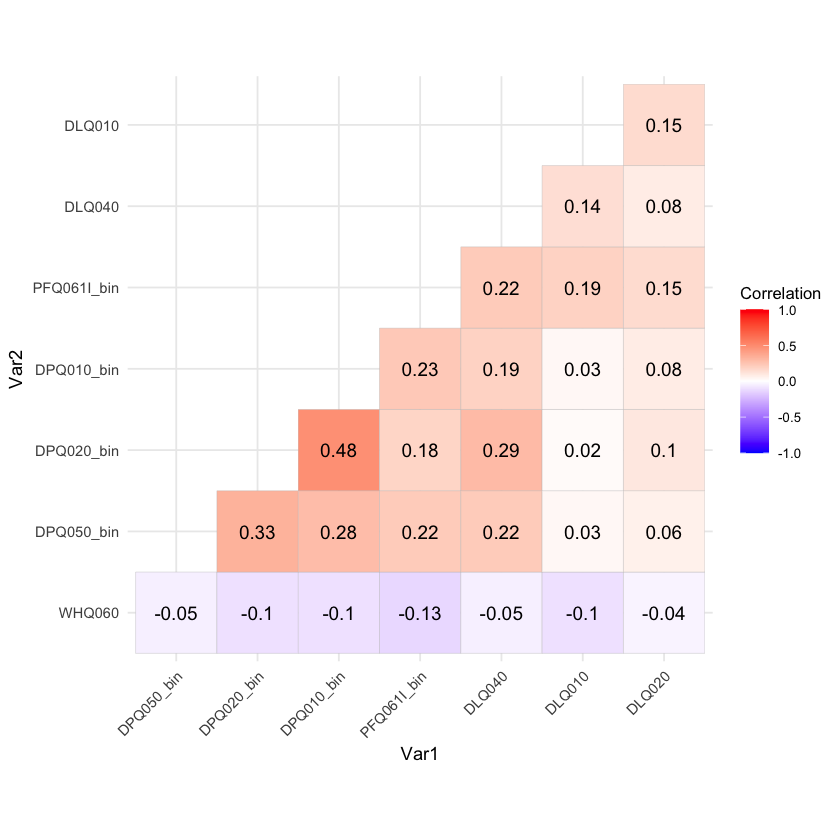

In [65]:
# Correlation matrix

library(ggcorrplot)
library(ggplot2)

corr <- cor(df[intrinsic_vars])

p <- ggcorrplot(corr, 
                hc.order = TRUE, 
                type = "lower", 
                lab = TRUE, 
                show.legend = TRUE) +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0, limit = c(-1, 1)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust=1),
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8)) +
  labs(fill = "Correlation")

p

In [41]:
# PCA

pca <- prcomp(df[intrinsic_vars],
              scale = T,
              center = T)

summary(pca)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.4802 1.0976 0.9842 0.9460 0.88422 0.86767 0.84624
Proportion of Variance 0.2739 0.1506 0.1211 0.1119 0.09773 0.09411 0.08951
Cumulative Proportion  0.2739 0.4245 0.5456 0.6574 0.75515 0.84925 0.93877
                           PC8
Standard deviation     0.69990
Proportion of Variance 0.06123
Cumulative Proportion  1.00000

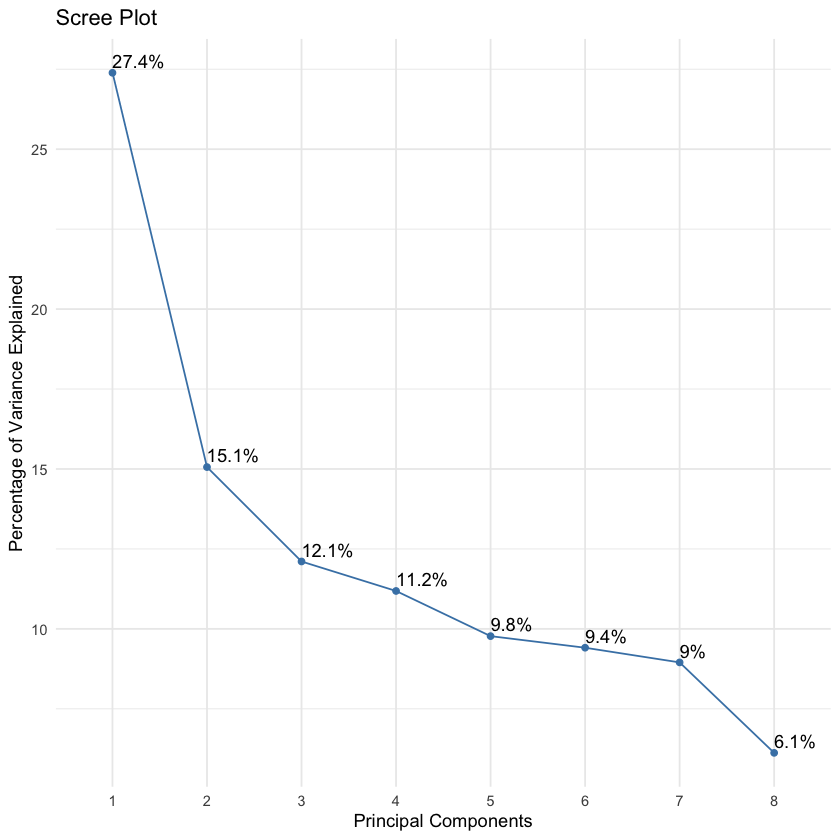

In [51]:
# screeplot

library(factoextra)

fviz_screeplot(pca, 
               geom = "line", 
               linecolor = "steelblue", 
               linetype = "solid", 
               addlabels = TRUE) +
  theme_minimal() +
  labs(title = "Scree Plot",
       x = "Principal Components",
       y = "Percentage of Variance Explained")

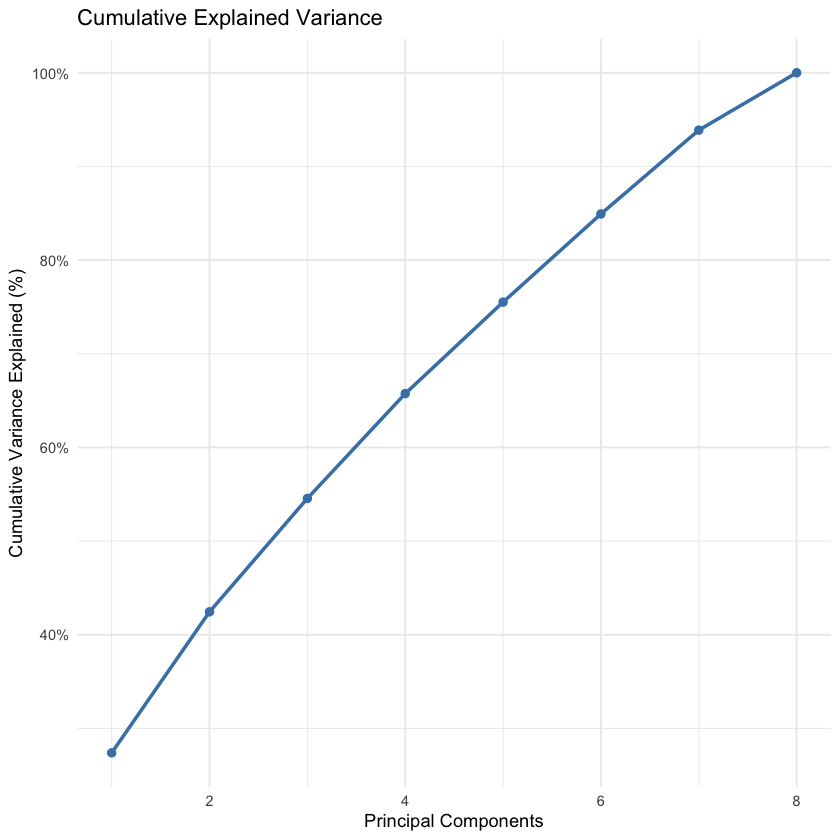

In [54]:
# Plot cumulative explained variance

# Calculate cumulative explained variance
explained_var <- pca$sdev^2 / sum(pca$sdev^2)
cum_explained_var <- cumsum(explained_var)
cumvar_df <- data.frame(
  PC = seq_along(cum_explained_var),
  CumulativeVariance = cum_explained_var
)

ggplot(cumvar_df, aes(x = PC, y = CumulativeVariance)) +
  geom_line(color = "steelblue", size = 1) +
  geom_point(color = "steelblue", size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  theme_minimal() +
  labs(title = "Cumulative Explained Variance",
       x = "Principal Components",
       y = "Cumulative Variance Explained (%)")


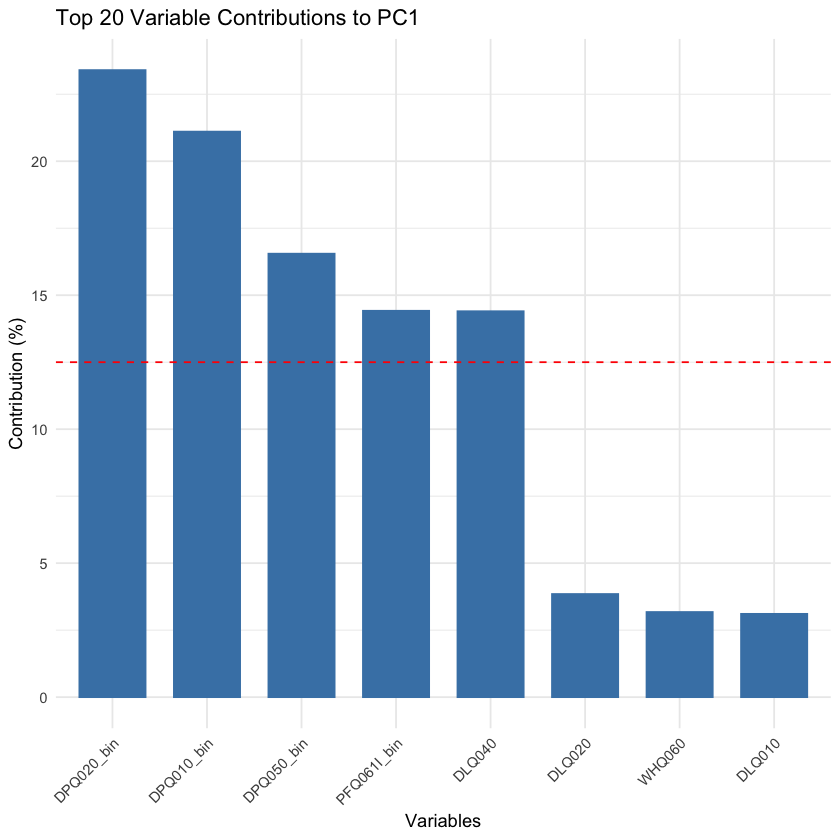

In [58]:
# Plot top variable contributions to PC1

fviz_contrib(pca, 
             choice = "var", 
             axes = 1, 
             top = 20, 
             fill = "steelblue", 
             color = "steelblue") +
  theme_minimal() +
  labs(title = "Top 20 Variable Contributions to PC1",
       x = "Variables",
       y = "Contribution (%)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

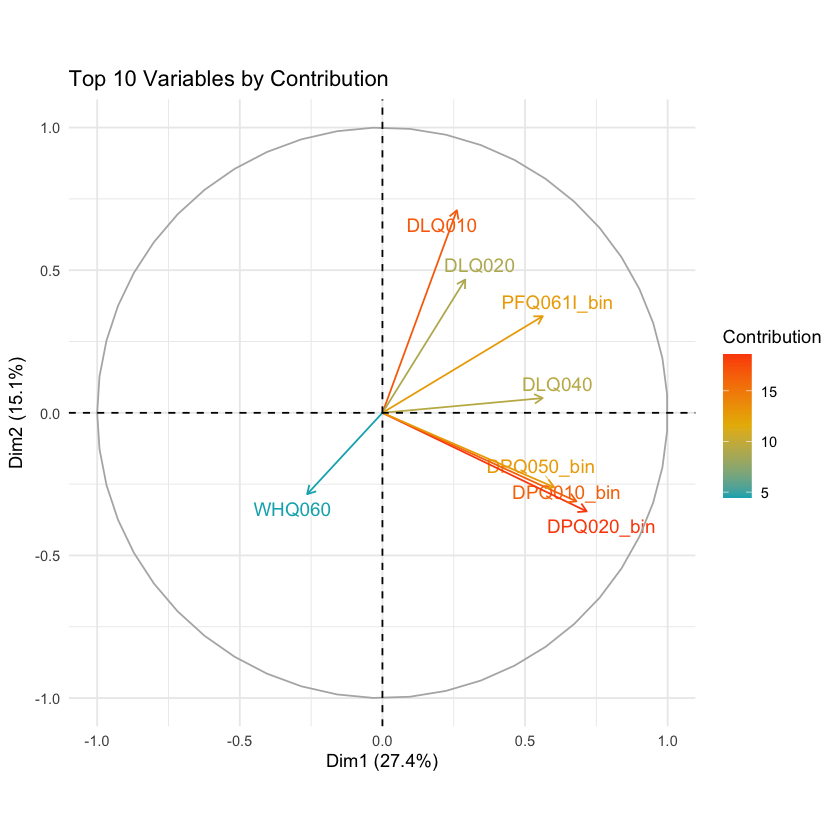

In [59]:
# PCA variable plot - top 10 contributing variables

fviz_pca_var(pca, 
             col.var = "contrib", 
             select.var = list(contrib = 10), 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) +
  theme_minimal() +
  labs(title = "Top 10 Variables by Contribution",
       color = "Contribution")

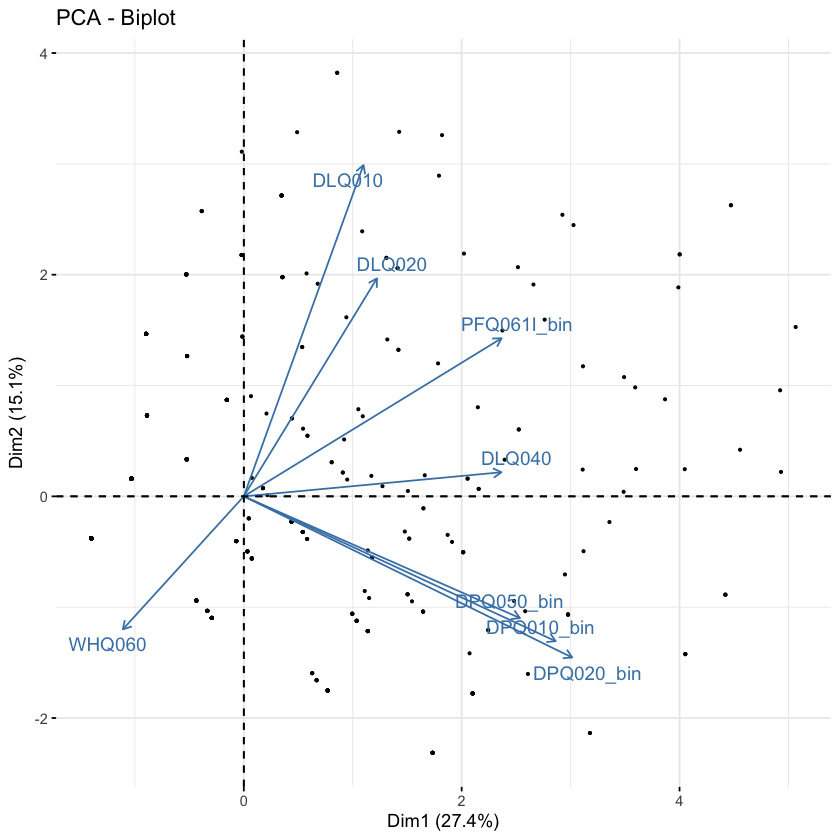

In [63]:
fviz_pca_biplot(pca, 
                select.var = list(contrib = 10), 
                label = 'var', 
                repel = T, 
                pointsize = 0.5)

#### Clustering

In [71]:
data_cluster <- df %>% 
    select(intrinsic_vars)

head(data_cluster)

,PFQ061I_bin,DLQ040,WHQ060,DPQ050_bin,DPQ020_bin,DPQ010_bin,DLQ010,DLQ020
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0
3,0,0,1,1,1,0,0,1
4,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0
6,1,0,1,0,0,0,1,0


In [72]:
# need to make variables as factors



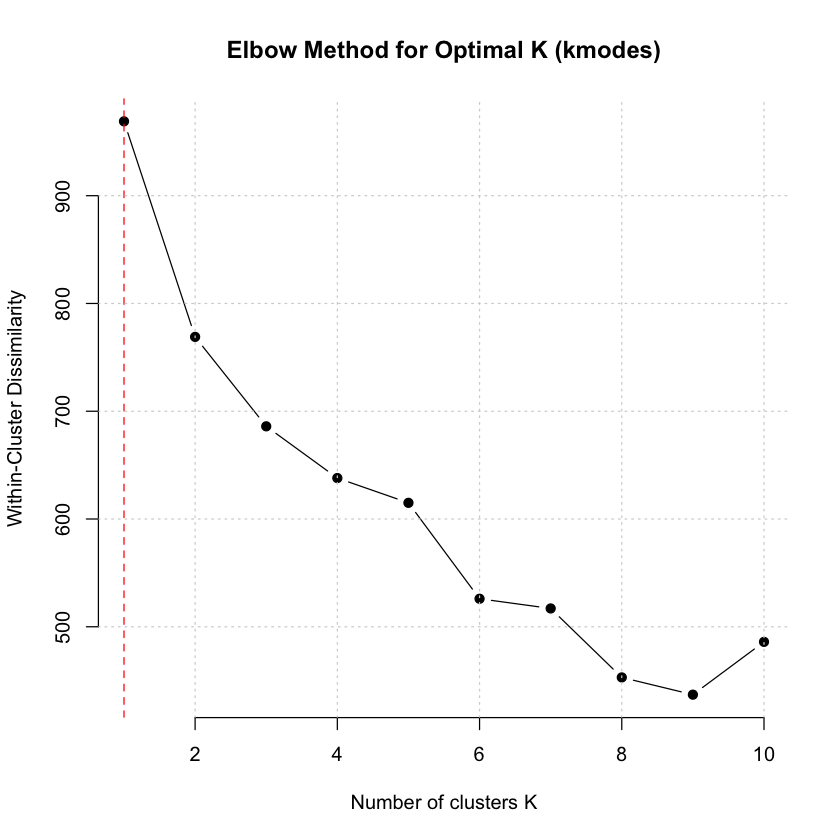

In [86]:
library(klaR)
library(factoextra)

# Wrapper for kmodes
kmodes_wrapper <- function(x, k) {
  klaR::kmodes(x, modes = k, iter.max = 10)
}

set.seed(123)

# Calculate total within-cluster dissimilarity for different k values
wss <- sapply(1:10, function(k) {
  model <- kmodes(data_cluster, k)  
  return(sum(model$withindiff))
})

# Plot WSS (Within-Cluster Dissimilarity) against K
par(bg = "white")
plot(1:10, wss, type = "b", pch = 19, frame = FALSE,
     xlab = "Number of clusters K", 
     ylab = "Within-Cluster Dissimilarity",
     main = "Elbow Method for Optimal K (kmodes)")
abline(v = which.min(diff(wss)), col = "red", lty = 2)
grid()

### Data Exploration and Visualization

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)
library(forcats)
library(corrplot)
library(GGally)
library(viridis)
library(patchwork)

In [ ]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

In [ ]:
# Conversion of the variable periodontitis into factor with specific order

df$periodontitis <- factor(df$periodontitis, 
                          levels = c("None/Mild", "Moderate", "Severe"),
                          ordered = TRUE)

In [ ]:
# Bar graph for periodontitis distribution

df_count <- df %>%
  count(periodontitis) %>%
  mutate(percent = round(n / sum(n) * 100, 1))

ggplot(df_count, aes(x = periodontitis, y = n, fill = periodontitis)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = paste0("", n, " (", percent, "%)")),
            vjust = -0.5, size = 5, fontface = "bold") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "",
       x = "",
       y = "Counts",
       fill = "Severity") +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 16),
    axis.text.y = element_text(size = 14),
    axis.title.y = element_text(size = 14, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 13, face = "bold")
  )


In [ ]:
# Gender Encoding
df$gender <- factor(df$RIAGENDR, 
                   levels = c(1, 2), 
                   labels = c("Male", "Female"))

# Stacked bar graph for periodontitis by gender
ggplot(df, aes(x = gender, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis Distribution for Gender",
       x = "Gender",
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Side-by-side bar graph for periodontitis by gender

df_count <- df %>%
  group_by(gender, periodontitis) %>%
  count() %>%
  group_by(gender) %>%
  mutate(percent = round(n / sum(n) * 100, 2))


options(repr.plot.width = 12, repr.plot.height = 8) 

ggplot(df_count, aes(x = gender, y = n, fill = periodontitis)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(aes(label = paste0(n, " (", percent, "%)")),
            position = position_dodge(width = 0.9),
            vjust = -0.5, size = 5, fontface = "bold") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "",
       x = "Gender", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 16),
    axis.text.y = element_text(size = 14),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 13, face = "bold")
  )

In [ ]:
# Age and Periodontitis

df_stats <- df %>%
  group_by(periodontitis) %>%
  summarise(
    mean_age = mean(RIDAGEYR, na.rm = TRUE),
    sd_age = sd(RIDAGEYR, na.rm = TRUE)
  ) %>%
  mutate(legend_label = paste(periodontitis, 
                              " (Mean: ", round(mean_age, 1), 
                              ", SD: ", round(sd_age, 1), ")", sep = ""))

ggplot(df, aes(x = periodontitis, y = RIDAGEYR, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8, labels = df_stats$legend_label) +
  labs(title = "",
       x = "", 
       y = "Age (years)",
       fill = "Severity") +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 16),
    axis.text.y = element_text(size = 14),
    axis.title.y = element_text(size = 14, face = "bold"),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 15, face = "bold")
  )

In [ ]:
# Socio-Economic Condition (INDFMPIR) and Periodontitis

ggplot(df, aes(x = periodontitis, y = INDFMPIR, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Poverty Index for Severity of Periodontitis",
       x = "Severity of periodontitis", 
       y = "Poverty Index (INDFMPIR)",
       caption = "Higher values indicate better economic condition",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Ethnicity and Periodontitis
# Encoding RIDRETH1 (ethnicity)

df$ethnicity <- factor(df$RIDRETH1, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Mexican American",
                                 "Other Hispanic",
                                 "Non-Hispanic White",
                                 "Non-Hispanic Black",
                                 "Other Race"))

ggplot(df, aes(x = ethnicity, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Distribution of Periodontitis by Ethnicity",
       x = "Ethnicity", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

In [ ]:
# Bar graph side-by-side for ethnicity and periodontitis

ggplot(df, aes(x = ethnicity, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Distribution of Periodontitis by Ethnicity",
       x = "Ethnicity", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

In [ ]:
# Education Level and Periodontitis
# Encoding DMDEDUC2 (education)
df$education <- factor(df$DMDEDUC2, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Less than 9th grade",
                                 "9-11th grade",
                                 "High school graduate",
                                 "Some college/AA degree",
                                 "College graduate or above"))

ggplot(df, aes(x = education, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by level of education",
       x = "Education Level", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

In [ ]:
# Side-by-side bar graph for education and periodontitis

ggplot(df, aes(x = education, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by level of education",
       x = "Education Level", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

In [ ]:
# FACET GRID FOR PERIODONTITIS BY GENDER AND AGE
# Creation of age groups
df$age_group <- cut(df$RIDAGEYR, 
                   breaks = c(59, 65, 70, 75, 81),
                   labels = c("60-65", "66-70", "71-75", "76-80"),
                   include.lowest = TRUE)

ggplot(df, aes(x = periodontitis, fill = periodontitis)) +
  geom_bar() +
  facet_grid(gender ~ age_group) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by gender and age group",
       x = "Periodontitis Severity", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        strip.text = element_text(size = 10, face = "bold"))

In [ ]:
# Boxplot for mean_ppd
ppd_plot <- ggplot(df, aes(x = periodontitis, y = mean_ppd, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Average Depth of Periodontal Pockets",
       x = "Periodontitis Severity",
       y = "Mean PPD (mm)",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "none",
        plot.title = element_text(hjust = 0.5, face = "bold", size = 10))

# Boxplot per mean_cal
cal_plot <- ggplot(df, aes(x = periodontitis, y = mean_cal, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Average Loss of Clinical Attack",
       x = "Periodontitis Severity",
       y = "Mean CAL (mm)",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "none",
        plot.title = element_text(hjust = 0.5, face = "bold", size = 10))

# Combine two plots
ppd_plot / cal_plot +
  plot_annotation(
    title = "Clinical Measures for Periodontitis Severity",
    theme = theme(plot.title = element_text(hjust = 0.5, face = "bold"))
  ) +
  plot_layout(guides = "collect") & 
  theme(legend.position = "bottom")

In [ ]:
# Correlation between clinical measures: scatterplot with regression line

ggplot(df, aes(x = mean_ppd, y = mean_cal, color = periodontitis)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = TRUE, alpha = 0.2) +
  scale_color_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Correlation between Depth of Pockets and Loss of Attack",
       x = "Average Depth of Periodontal Pockets (mm)",
       y = "Average Loss of Clinical Attack (mm)",
       color = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Encoding SMQ020
df$smoking_status <- factor(df$SMQ020, 
                           levels = c(1, 2), 
                           labels = c("Yes", "No"))

mosaic_data <- table(df$smoking_status, df$periodontitis)

mosaic_df <- as.data.frame(mosaic_data)
names(mosaic_df) <- c("Smoking", "Periodontitis", "Count")

ggplot(mosaic_df, aes(x = Smoking, y = Count, fill = Periodontitis)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Smoking and Periodontitis",
       x = "Smoking Status",
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Side-by-side bar graph for smoke and periodontitis

ggplot(df, aes(x = smoking_status, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Smoking and Periodontitis",
       x = "Smoking Status", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Encoding DIQ010 (Diabetes)
df$diabetes <- factor(df$DIQ010, 
                     levels = c(1, 2, 3), 
                     labels = c("Yes", "No", "Borderline"))

# Contingency table
diabetes_perio <- table(df$diabetes, df$periodontitis)
diabetes_perio_df <- as.data.frame(diabetes_perio)
names(diabetes_perio_df) <- c("Diabetes", "Periodontitis", "Count")

ggplot(diabetes_perio_df, aes(x = Diabetes, y = Count, fill = Periodontitis)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Diabetes and Periodontitis",
       x = "Diabetes", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Side-by-side bar graph for diabetes and periodontitis

ggplot(df, aes(x = diabetes, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Diabetes and Periodontitis",
       x = "Diabetes", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Encoding BPQ020 (hypertension)
df$hypertension <- factor(df$BPQ020, 
                         levels = c(1, 2), 
                         labels = c("Yes", "No"))

ggplot(df, aes(x = hypertension, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between hypertension and periodontitis",
       x = "Hypertension", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

In [ ]:
# Side-by-side bar chart for hypertension and periodontitis

ggplot(df, aes(x = hypertension, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between hypertension and periodontitis",
       x = "Hypertension", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

#### Visualization with Plotly

In [ ]:
library(plotly)
library(dplyr)
library(tidyr)

In [ ]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

In [ ]:
# Conversion of the variable periodontitis into factor with specific order
df$periodontitis <- factor(df$periodontitis, 
                          levels = c("None/Mild", "Moderate", "Severe"),
                          ordered = TRUE)

# Coding of categorical variables
df <- df %>%
  mutate(
    # Demografiche
    gender = factor(RIAGENDR, levels = c(1, 2), labels = c("Male", "Female")),
    
    ethnicity = factor(RIDRETH1, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Mexican American",
                                 "Other Hispanic",
                                 "Non-Hispanic White",
                                 "Non-Hispanic Black",
                                 "Other Race")),
    
    education = factor(DMDEDUC2, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Less than 9th grade",
                                 "9-11th grade",
                                 "High school graduate",
                                 "Some college/AA degree",
                                 "College graduate or above")),
    
    smoking_status = factor(SMQ020, 
                           levels = c(1, 2), 
                           labels = c("Yes", "No")),
    
    alcohol_use = factor(ALQ101, 
                        levels = c(1, 2), 
                        labels = c("Yes", "No")),
    
    hypertension = factor(BPQ020, 
                         levels = c(1, 2), 
                         labels = c("Yes", "No")),
    
    diabetes = factor(DIQ010, 
                     levels = c(1, 2, 3), 
                     labels = c("Yes", "No", "Borderline")),
    
    depression_little_interest = factor(DPQ010_bin, 
                                      levels = c(0, 1), 
                                      labels = c("No", "Yes")),
    
    depression_feeling_down = factor(DPQ020_bin, 
                                   levels = c(0, 1), 
                                   labels = c("No", "Yes")),
    
    depression_feeling_failure = factor(DPQ050_bin, 
                                      levels = c(0, 1), 
                                      labels = c("No", "Yes")),
    
    age_group = cut(RIDAGEYR, 
                   breaks = c(59, 65, 70, 75, 81),
                   labels = c("60-65", "66-70", "71-75", "76-80"),
                   include.lowest = TRUE)
  )

# Renames variables
df <- df %>%
  rename(
    Age = RIDAGEYR,
    Income_Ratio = INDFMPIR,
    PPD = mean_ppd,
    CAL = mean_cal
  )

In [ ]:
# Distribution of periodontitis

plot1 <- df %>%
  count(periodontitis) %>%
  plot_ly(x = ~periodontitis, y = ~n, type = 'bar',
          marker = list(color = c('#FDE725', '#5DC963', '#3B528B')),
          text = ~n, textposition = 'auto') %>%
  layout(title = "Distribution of Periodontitis",
         xaxis = list(title = "Severity of periodontitis"),
         yaxis = list(title = "Count"))

plot1

In [ ]:
# Periodontitis by gender (side bars)
plot2 <- df %>%
  count(gender, periodontitis) %>%
  plot_ly(x = ~gender, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Periodontitis distribution by gender",
         xaxis = list(title = "Gender"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))
        
plot2

In [ ]:
# Age and Periodontitis (boxplot)

plot3 <- plot_ly(df, y = ~Age, color = ~periodontitis, type = "box",
                colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Age Distribution for Severity of Periodontitis",
         xaxis = list(title = "Severity of Periodontitis"),
         yaxis = list(title = "Age (years)"),
         legend = list(title = list(text = "Severity")))

plot3

In [ ]:
# Clinical measurements scatter plot

plot4 <- plot_ly(df, x = ~PPD, y = ~CAL, color = ~periodontitis, type = "scatter", mode = "markers",
                colors = c('#FDE725', '#5DC963', '#3B528B'),
                marker = list(size = 8, opacity = 0.7),
                text = ~paste("Periodontitis: ", periodontitis, 
                             "<br>PPD: ", PPD, 
                             "<br>CAL: ", CAL, 
                             "<br>Age: ", Age)) %>%
  layout(title = "Relationship between Pocket Depth and Attack Loss",
         xaxis = list(title = "Average Depth of Pockets PPD (mm)"),
         yaxis = list(title = "Average Loss of Attack CAL (mm)"),
         legend = list(title = list(text = "Severity")))

plot4

In [ ]:
# Smoking status and Periodontitis (side bars)

plot5 <- df %>%
  count(smoking_status, periodontitis) %>%
  plot_ly(x = ~smoking_status, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Relationship Smoking status and Periodontitis",
         xaxis = list(title = "Smoking Status"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot5

In [ ]:
# Diabetes and periodontitis (side-by-side bars)

plot6 <- df %>%
  count(diabetes, periodontitis) %>%
  plot_ly(x = ~diabetes, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Relationship between Diabetes and Periodontitis",
         xaxis = list(title = "Diabetes"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot6

In [ ]:
# Hypertension and Periodontitis (side-by-side bars)

plot7 <- df %>%
  count(hypertension, periodontitis) %>%
  plot_ly(x = ~hypertension, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Relationship between Hypertension and Periodontitis",
         xaxis = list(title = "Hypertension"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot7

In [ ]:
# Ethnicity and periodontitis (side-by-side bars)

plot8 <- df %>%
  count(ethnicity, periodontitis) %>%
  plot_ly(x = ~ethnicity, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Distribution of Periodontitis by Ethnicity",
         xaxis = list(title = "Ethnicity"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot8

In [ ]:
# Education and periodontitis (side-by-side bars)

plot9 <- df %>%
  count(education, periodontitis) %>%
  plot_ly(x = ~education, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Periodontitis distribution by level of education",
         xaxis = list(title = "Education Level"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot9

In [ ]:
# Depression (little interest) and periodontitis (side-by-side bars)

plot10 <- df %>%
  count(depression_little_interest, periodontitis) %>%
  plot_ly(x = ~depression_little_interest, y = ~n, color = ~periodontitis, type = 'bar',
          colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Relationship between Low Interest (Depression) and Periodontitis",
         xaxis = list(title = "Little Interest"),
         yaxis = list(title = "Count"),
         barmode = 'group',
         legend = list(title = list(text = "Severity")))

plot10

In [ ]:
# Socio-economic condition and periodontitis (boxplot)

plot11 <- plot_ly(df, y = ~Income_Ratio, color = ~periodontitis, type = "box",
                 colors = c('#FDE725', '#5DC963', '#3B528B')) %>%
  layout(title = "Poverty Index for Severity of Periodontitis",
         xaxis = list(title = "Severity of periodontitis"),
         yaxis = list(title = "Poverty Index (INDFMPIR)"),
         legend = list(title = list(text = "Severity")))

plot11

In [ ]:
# Istogramma distribuzione PPD con slider interattivo

plot12 <- plot_ly(df, x = ~PPD, type = "histogram",
                 histnorm = "count",
                 marker = list(color = "#3B528B"),
                 nbinsx = 30) %>%
  layout(title = "Distribution of the Average Depth of Pockets PPD",
         xaxis = list(title = "Average Depth of Pockets PPD (mm)"),
         yaxis = list(title = "Count"),
         updatemenus = list(
           list(
             type = "buttons",
             direction = "left",
             x = 0.1,
             y = 1.2,
             buttons = list(
               list(method = "restyle",
                    args = list(list(histnorm = "count")),
                    label = "Count"),
               list(method = "restyle",
                    args = list(list(histnorm = "probability")),
                    label = "Probability"),
               list(method = "restyle",
                    args = list(list(histnorm = "density")),
                    label = "Density")
             )
           )
         ))

plot12

In [ ]:
# Proof of Concept: Dashboard with subplot (grid 2x2)

dashboard <- subplot(
  plot2, plot4,
  plot5, plot6,
  nrows = 2, 
  titleY = TRUE,
  titleX = TRUE,
  margin = 0.1
) %>% 
  layout(title = "Dashboard Periodontitis: demographic and risk factors",
         showlegend = TRUE)

dashboard